<div style="text-align: center;">
    <h1>RESEARCH PROJECT PART 3</h1>
</div>

<div style="text-align: center;">
     The primary goal of this Jupyter notebook is to train both machine learning and deep learning models, using hyperparameter fine-tuning, and evaluate the impact of feature selection methods on machine learning models as well.
</div>

# 1. Preparing The Environment

In [62]:
#libraries for dfs 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for time 
import time
from timeit import default_timer as timer
from datetime import timedelta

#libraries for metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.metrics import AUC

#libraries for algorithms
import tensorflow as tf  
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from deepctr.models import WDL
from deepctr.models import DeepFM
from deepctr.models import xDeepFM

#libaries for features
import shap
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, MinMaxScaler #for deep learning preprocessing
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names #for deep learning preprocessing

#libraries for optimisation
import optuna
from optuna.integration import TFKerasPruningCallback
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tensorflow.keras.optimizers import Adam

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import GridSearchCV
from dask_ml.preprocessing import Categorizer

#other libraries
from wakepy import keep #keep programs running despite inactivity 
from tqdm import tqdm #progress bar
from dask.diagnostics import ProgressBar
import warnings #supress warnings 
warnings.filterwarnings("ignore")
import random  #random operations
import logging  #logging for debugging or tracking
import joblib
from joblib import dump, load
from keras.models import load_model

### 1.1. Loading the datasets:

In [38]:
Xtrain = pd.read_csv("Xtrain_new_exp.csv")
Xtest = pd.read_csv("Xtest_new_exp.csv")

ytrain = pd.read_csv("ytrain_new_exp.csv").squeeze()
ytest = pd.read_csv("ytest_new_exp.csv").squeeze()

### 1.2. Inspect the datasets:

In [202]:
Xtrain.shape

(99568, 110)

In [203]:
ytrain.shape

(99568,)

In [204]:
Xtest.shape

(13524, 110)

In [205]:
ytest.shape

(13524,)

# 2. Baseline:

### 2.1. Training set:

In [206]:
#create a dummy classifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)

#predict the class labels
yhat_train = dummy_clf.predict(Xtrain)

#evaluate the performance of dummy classifier on the training set
precision, recall, fscore, _ = precision_recall_fscore_support(ytrain, yhat_train, average="macro", zero_division=0)
auc_score = roc_auc_score(ytrain, yhat_train)

print("Baseline:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {fscore:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Baseline:
Precision: 0.468
Recall: 0.500
F1 Score: 0.484
AUC Score: 0.500


### 2.2. Testing set:

In [207]:
#test the dummy variable on the testing set
yhat_test = dummy_clf.predict(Xtest)
auc_score = roc_auc_score(ytrain, yhat_train)

#evaluate its performance
p, r, f, s = precision_recall_fscore_support(ytest, yhat_test, average="macro", zero_division=0)
print("Baseline:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Baseline:
Precision: 0.465
Recall: 0.500
F score: 0.482
AUC Score: 0.500


The baseline AUC of 0.5 from the dummy classifier reflects random guessing result, as expected.

# 3. Machine Learning Models:

The models picked for the evaluation are Decision Tree, CatBoost, and a simple custom Keras MLP.

## 3.1. Decision Tree:

### 3.1.1. Best model performance:

#### 3.1.1.1. Hyperparameters optimisation:

In [208]:
#record execution time
start = timer()

#define the objective function for Optuna
def objective_dt(trial_dt):
    #suggest values for the hyperparameters
    max_depth_dt = trial_dt.suggest_int("max_depth", 5, 40, step=5)
    min_samples_split_dt = trial_dt.suggest_int("min_samples_split", 5, 35, step=5)

    #set up the DecisionTreeClassifier with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        random_state=7,
        class_weight="balanced",
        max_depth=max_depth_dt,
        min_samples_split=min_samples_split_dt
    )

    #perform cross-validation and return the mean AUC score
    cv_dt = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    scores_dt = cross_val_score(
        dt_classifier, Xtrain, ytrain, cv=cv_dt, scoring="roc_auc", n_jobs=-1
    )
    return scores_dt.mean()

#optimise the objective function
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt, n_trials=20, show_progress_bar=True)

#print execution time
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

[I 2024-12-07 02:03:19,331] A new study created in memory with name: no-name-fdd76915-5964-4daa-b983-325e16dbe24e
Best trial: 0. Best value: 0.944953:   5%|██▎                                           | 1/20 [00:06<01:57,  6.19s/it]

[I 2024-12-07 02:03:25,516] Trial 0 finished with value: 0.9449534374619271 and parameters: {'max_depth': 35, 'min_samples_split': 35}. Best is trial 0 with value: 0.9449534374619271.


Best trial: 1. Best value: 0.963601:  10%|████▌                                         | 2/20 [00:08<01:08,  3.82s/it]

[I 2024-12-07 02:03:27,683] Trial 1 finished with value: 0.9636007354691551 and parameters: {'max_depth': 15, 'min_samples_split': 10}. Best is trial 1 with value: 0.9636007354691551.


Best trial: 2. Best value: 0.973679:  15%|██████▉                                       | 3/20 [00:09<00:46,  2.73s/it]

[I 2024-12-07 02:03:29,111] Trial 2 finished with value: 0.9736793202134608 and parameters: {'max_depth': 10, 'min_samples_split': 25}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  20%|█████████▏                                    | 4/20 [00:10<00:33,  2.10s/it]

[I 2024-12-07 02:03:30,259] Trial 3 finished with value: 0.9056988518585157 and parameters: {'max_depth': 30, 'min_samples_split': 10}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  25%|███████████▌                                  | 5/20 [00:12<00:26,  1.75s/it]

[I 2024-12-07 02:03:31,370] Trial 4 finished with value: 0.9611623020594173 and parameters: {'max_depth': 15, 'min_samples_split': 5}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  30%|█████████████▊                                | 6/20 [00:13<00:22,  1.63s/it]

[I 2024-12-07 02:03:32,785] Trial 5 finished with value: 0.8950590230683927 and parameters: {'max_depth': 35, 'min_samples_split': 10}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  35%|████████████████                              | 7/20 [00:15<00:21,  1.66s/it]

[I 2024-12-07 02:03:34,492] Trial 6 finished with value: 0.9449534374619271 and parameters: {'max_depth': 35, 'min_samples_split': 35}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  40%|██████████████████▍                           | 8/20 [00:16<00:19,  1.61s/it]

[I 2024-12-07 02:03:35,986] Trial 7 finished with value: 0.9056988518585157 and parameters: {'max_depth': 30, 'min_samples_split': 10}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  45%|████████████████████▋                         | 9/20 [00:17<00:15,  1.45s/it]

[I 2024-12-07 02:03:37,083] Trial 8 finished with value: 0.9608922014927954 and parameters: {'max_depth': 5, 'min_samples_split': 25}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  50%|██████████████████████▌                      | 10/20 [00:19<00:14,  1.42s/it]

[I 2024-12-07 02:03:38,441] Trial 9 finished with value: 0.9684502991339137 and parameters: {'max_depth': 15, 'min_samples_split': 30}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  55%|████████████████████████▊                    | 11/20 [00:20<00:12,  1.42s/it]

[I 2024-12-07 02:03:39,864] Trial 10 finished with value: 0.9608922014927954 and parameters: {'max_depth': 5, 'min_samples_split': 20}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  60%|███████████████████████████                  | 12/20 [00:22<00:11,  1.45s/it]

[I 2024-12-07 02:03:41,370] Trial 11 finished with value: 0.9686244261500427 and parameters: {'max_depth': 15, 'min_samples_split': 25}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  65%|█████████████████████████████▎               | 13/20 [00:23<00:10,  1.49s/it]

[I 2024-12-07 02:03:42,959] Trial 12 finished with value: 0.9505883308823659 and parameters: {'max_depth': 20, 'min_samples_split': 20}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  70%|███████████████████████████████▍             | 14/20 [00:24<00:08,  1.44s/it]

[I 2024-12-07 02:03:44,274] Trial 13 finished with value: 0.9736793202134608 and parameters: {'max_depth': 10, 'min_samples_split': 25}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  75%|█████████████████████████████████▊           | 15/20 [00:26<00:07,  1.43s/it]

[I 2024-12-07 02:03:45,686] Trial 14 finished with value: 0.9736793202134608 and parameters: {'max_depth': 10, 'min_samples_split': 25}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  80%|████████████████████████████████████         | 16/20 [00:27<00:05,  1.42s/it]

[I 2024-12-07 02:03:47,090] Trial 15 finished with value: 0.947040968489717 and parameters: {'max_depth': 25, 'min_samples_split': 30}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 2. Best value: 0.973679:  85%|██████████████████████████████████████▎      | 17/20 [00:29<00:04,  1.42s/it]

[I 2024-12-07 02:03:48,503] Trial 16 finished with value: 0.9732166331973883 and parameters: {'max_depth': 10, 'min_samples_split': 15}. Best is trial 2 with value: 0.9736793202134608.


Best trial: 17. Best value: 0.973684:  90%|███████████████████████████████████████▌    | 18/20 [00:30<00:02,  1.40s/it]

[I 2024-12-07 02:03:49,854] Trial 17 finished with value: 0.9736836704732699 and parameters: {'max_depth': 10, 'min_samples_split': 30}. Best is trial 17 with value: 0.9736836704732699.


Best trial: 17. Best value: 0.973684:  95%|█████████████████████████████████████████▊  | 19/20 [00:32<00:01,  1.43s/it]

[I 2024-12-07 02:03:51,347] Trial 18 finished with value: 0.9559449995487602 and parameters: {'max_depth': 20, 'min_samples_split': 30}. Best is trial 17 with value: 0.9736836704732699.


Best trial: 17. Best value: 0.973684: 100%|████████████████████████████████████████████| 20/20 [00:33<00:00,  1.66s/it]

[I 2024-12-07 02:03:52,604] Trial 19 finished with value: 0.9608922014927954 and parameters: {'max_depth': 5, 'min_samples_split': 35}. Best is trial 17 with value: 0.9736836704732699.
Execution time HH:MM:SS: 0:00:33.301220


In [209]:
#print the best parameters 
print("Best parameters:", study_dt.best_params)

Best parameters: {'max_depth': 10, 'min_samples_split': 30}


In [210]:
#print the best AUC score 
print("Best AUC score:", study_dt.best_value)

Best AUC score: 0.9736836704732699


In [211]:
#record execution time for model training with best parameters
start = timer()

#set up the best decision tree model using the best parameters from Optuna
best_dt_model = DecisionTreeClassifier(
    random_state=7,
    class_weight="balanced",
    max_depth=study_dt.best_params['max_depth'],
    min_samples_split=study_dt.best_params['min_samples_split']
)

#fit the best model on the training data
best_dt_model.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=30, random_state=7)

#### 3.1.1.2. Training set prediction:

In [212]:
#record prediction time
start = timer()

#predict on the training data
yhat_dt = best_dt_model.predict(Xtrain)

#print prediction time
print("Prediction time HH:MM:SS:", timedelta(seconds=timer() - start))

Prediction time HH:MM:SS: 0:00:00.061412


In [213]:
#evaluate the performance
p, r, f, s = precision_recall_fscore_support(ytrain, yhat_dt, average="macro", zero_division=0)
auc_score = roc_auc_score(ytrain, yhat_dt)

print("Decision Tree:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Decision Tree:
Precision: 0.739
Recall: 0.963
F score: 0.805
AUC Score: 0.963


#### 3.1.1.3. Testing set prediction:

In [214]:
#record prediction time
start = timer()

#predict on the training data
yhat_dt = best_dt_model.predict(Xtest)

#print prediction time
print("Prediction time HH:MM:SS:", timedelta(seconds=timer() - start))

Prediction time HH:MM:SS: 0:00:00.010590


In [215]:
#evaluate the performance
p, r, f, s = precision_recall_fscore_support(ytest, yhat_dt, average="macro", zero_division=0)
auc_score = roc_auc_score(ytest, yhat_dt)

print("Decision Tree:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Decision Tree:
Precision: 0.720
Recall: 0.919
F score: 0.776
AUC Score: 0.919


Decision Tree achieved a training AUC score of 0.963 and a testing AUC score of 0.919, indicating strong performance with minimal overfitting.

### 3.1.2. Feature selection methods:

#### 3.1.2.1. RFE:

In [216]:
#initialise dask for parallel processing 
client = Client()

#convert Xtrain and Xtest into dask dfs 
Xtrain_dd = dd.from_pandas(Xtrain, npartitions=5)
Xtest_dd = dd.from_pandas(Xtest, npartitions=5)

#start the timer 
start_time = time.time()

#define a function to evaluate DT AUC score according to top 'n' features using RFE 
def evaluate_rfe(model, X_train, X_test, y_train, y_test, num_features):
    #initialise RFE 
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    
    #fit RFE 
    rfe.fit(X_train, y_train)

    #transform dfs to retain the selected features 
    Xtrain_rfe = rfe.transform(X_train)
    Xtest_rfe = rfe.transform(X_test)
    
    #fit the model with the reduced features 
    model.fit(Xtrain_rfe, y_train)
    
    #predict Xtest and calculate the AUC score 
    y_pred_rfe = model.predict(Xtest_rfe)
    auc = roc_auc_score(y_test, y_pred_rfe)
    
    return auc, rfe

#set up lists to store feature counts, AUC scores, and best features 
feature_counts_dt_rfe = [] 
auc_scores_dt_rfe = []
best_auc_dt_rfe = -1  #set best AUC score at below normal level initially
best_top_features_dt_rfe = []  #list to store features with the best AUC scores

#track the progress of the program  
print("Starting RFE and model evaluation process...")

#conduct initial evaluation with top 5 features 
initial_num_features = 5
auc_score_dt_rfe, rfe_dt_rfe = evaluate_rfe(best_dt_model, Xtrain, Xtest, ytrain, ytest, initial_num_features)
auc_scores_dt_rfe.append(auc_score_dt_rfe)
feature_counts_dt_rfe.append(initial_num_features)

#check for the best AUC score and update best_auc if found 
if auc_score_dt_rfe > best_auc_dt_rfe:
    best_auc_dt_rfe = auc_score_dt_rfe
    best_top_features_dt_rfe = [rfe_dt_rfe.support_]  #store the feature set that corresponds to the best AUC score

print(f"Top {initial_num_features} Features, AUC Score: {auc_score_dt_rfe:.3f}")

#define the range of feature increments being 10 
feature_steps = range(10, Xtrain.shape[1] + 1, 10)

#loop over feature steps, in increments of 10 
for num_features in tqdm(feature_steps, desc="Evaluating Features"):
    auc_score_dt_rfe, rfe_dt_rfe = evaluate_rfe(best_dt_model, Xtrain, Xtest, ytrain, ytest, num_features)
    
    #store results 
    auc_scores_dt_rfe.append(auc_score_dt_rfe)
    feature_counts_dt_rfe.append(num_features)

    #check for the best AUC score and update best_auc and best features if found
    if auc_score_dt_rfe > best_auc_dt_rfe:
        best_auc_dt_rfe = auc_score_dt_rfe
        best_top_features_dt_rfe = [rfe_dt_rfe.support_]  #update the list with the current best feature set (in the same order as RFE)  
    
    print(f"Top {num_features} Features, AUC Score: {auc_score_dt_rfe:.3f}")

#calculate total execution time 
execution_time = time.time() - start_time

#close dask client
client.close()

Starting RFE and model evaluation process...
Top 5 Features, AUC Score: 0.955


Evaluating Features:   9%|█████▋                                                        | 1/11 [00:34<05:45, 34.60s/it]

Top 10 Features, AUC Score: 0.961


Evaluating Features:  18%|███████████▎                                                  | 2/11 [01:07<05:03, 33.73s/it]

Top 20 Features, AUC Score: 0.929


Evaluating Features:  27%|████████████████▉                                             | 3/11 [01:38<04:20, 32.59s/it]

Top 30 Features, AUC Score: 0.920


Evaluating Features:  36%|██████████████████████▌                                       | 4/11 [02:08<03:38, 31.24s/it]

Top 40 Features, AUC Score: 0.920


Evaluating Features:  45%|████████████████████████████▏                                 | 5/11 [02:35<02:58, 29.67s/it]

Top 50 Features, AUC Score: 0.920


Evaluating Features:  55%|█████████████████████████████████▊                            | 6/11 [02:58<02:17, 27.48s/it]

Top 60 Features, AUC Score: 0.920


Evaluating Features:  64%|███████████████████████████████████████▍                      | 7/11 [03:17<01:39, 24.83s/it]

Top 70 Features, AUC Score: 0.920


Evaluating Features:  73%|█████████████████████████████████████████████                 | 8/11 [03:34<01:06, 22.24s/it]

Top 80 Features, AUC Score: 0.920


Evaluating Features:  82%|██████████████████████████████████████████████████▋           | 9/11 [03:46<00:38, 19.05s/it]

Top 90 Features, AUC Score: 0.919


Evaluating Features:  91%|███████████████████████████████████████████████████████▍     | 10/11 [03:53<00:15, 15.33s/it]

Top 100 Features, AUC Score: 0.919


Evaluating Features: 100%|█████████████████████████████████████████████████████████████| 11/11 [03:54<00:00, 21.33s/it]
2024-12-07 02:08:25,108 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:55916'.


Top 110 Features, AUC Score: 0.919


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

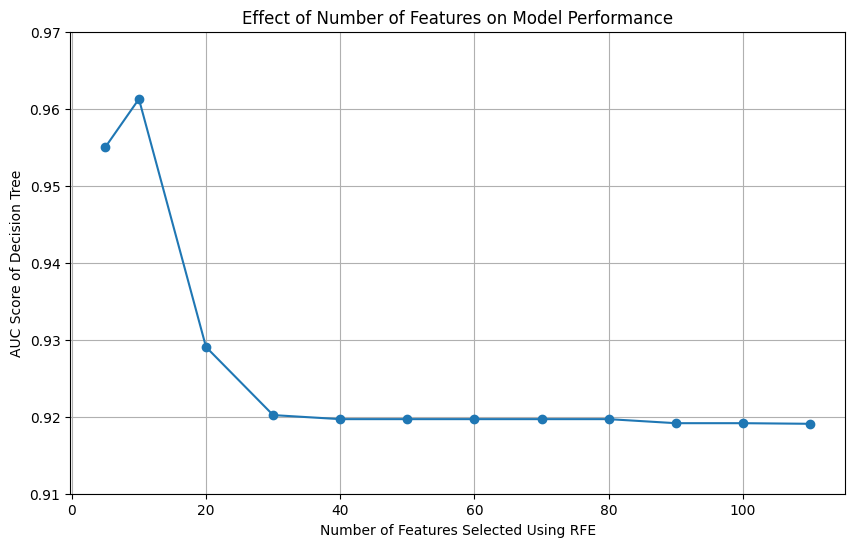

In [217]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(feature_counts_dt_rfe, auc_scores_dt_rfe, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using RFE')
plt.ylabel('AUC Score of Decision Tree')
plt.title('Effect of Number of Features on Model Performance')

RFE evaluation for Decision Tree revealed optimal performance with the top 10 features, achieving an AUC score of 0.961, but dropped significantly after, as increasing feature count beyond 20 led to diminishing returns with stable AUC scores around 0.919.

#### 3.1.2.2. Permutation:

In [218]:
#initialise Dask for parallel processing
client = Client()

#convert Xtrain and Xtest into Dask DataFrames
Xtrain_dd = dd.from_pandas(Xtrain, npartitions=5)
Xtest_dd = dd.from_pandas(Xtest, npartitions=5)

#start the timer
start_time = time.time()

#define a function to compute the permutation importance
def compute_importance(model, X, y):
    #convert Dask DataFrame to pandas DataFrame before passing to the model
    X_pd = X.compute()  # Ensure X is in pandas format
    result = permutation_importance(model, X_pd, y, n_repeats=10, random_state=7)
    return result.importances_mean

#calculate permutation importance in parallel using Dask
result_dt_perm = compute_importance(best_dt_model, Xtest_dd, ytest)

#create a DataFrame for feature importances
importances_dt_perm = pd.DataFrame({'feature': Xtest.columns, 'importance': result_dt_perm}).sort_values(by='importance', ascending=False)

#define a function to evaluate DT AUC score according to top 'n' features
def evaluate_with_top_n_features(model, X_train, X_test, y_train, y_test, top_n_features):
    #ensure top_n_features are selected correctly
    top_features_dt_perm = importances_dt_perm['feature'].head(top_n_features).values
    Xtrain_dt_perm = X_train[top_features_dt_perm]
    Xtest_dt_perm = X_test[top_features_dt_perm]

    #fit the model with the top 'n' features
    model.fit(Xtrain_dt_perm, y_train)
    y_pred_dt_perm = model.predict(Xtest_dt_perm)

    #calculate the AUC score  
    auc_perm = roc_auc_score(y_test, y_pred_dt_perm)
    return auc_perm, top_features_dt_perm

#set up lists to store feature counts, AUC scores, and best estimator
feature_counts_dt_perm = []
auc_scores_dt_perm = []
best_auc_dt_perm = -1
best_top_features_dt_perm = None

#track the progress of the program
print("Starting permutation and model evaluation process...")

#conduct initial evaluation with top 5 features
initial_top_n = 5
auc_score_dt_perm, top_features_dt_perm = evaluate_with_top_n_features(best_dt_model, Xtrain, Xtest, ytrain, ytest, initial_top_n)
auc_scores_dt_perm.append(auc_score_dt_perm)
feature_counts_dt_perm.append(initial_top_n)

#check for the best AUC score and update best_auc_dt_perm and best_top_features_dt_perm if found 
if auc_score_dt_perm > best_auc_dt_perm:
    best_auc_dt_perm = auc_score_dt_perm
    best_top_features_dt_perm = top_features_dt_perm

print(f"Top {initial_top_n} Features, AUC Score: {auc_score_dt_perm:.3f}")

#define the range of feature increments being 5
for top_n in tqdm(range(10, len(importances_dt_perm) + 1, 10)):
    auc_score_dt_perm, top_features_dt_perm = evaluate_with_top_n_features(best_dt_model, Xtrain, Xtest, ytrain, ytest, top_n)
    auc_scores_dt_perm.append(auc_score_dt_perm)
    feature_counts_dt_perm.append(top_n)

    #check for the best AUC score and update best_auc_dt_perm and best_top_features_dt_perm if found
    if auc_score_dt_perm > best_auc_dt_perm:
        best_auc_dt_perm = auc_score_dt_perm
        best_top_features_dt_perm = top_features_dt_perm

    print(f"Top {top_n} Features, AUC Score: {auc_score_dt_perm:.3f}")

#calculate the total execution time
execution_time = time.time() - start_time
print(f"Total execution time: {execution_time:.3f} seconds")

#close Dask client
client.close()

Starting permutation and model evaluation process...
Top 5 Features, AUC Score: 0.955


  9%|███████▌                                                                           | 1/11 [00:00<00:01,  8.92it/s]

Top 10 Features, AUC Score: 0.960
Top 20 Features, AUC Score: 0.929


 27%|██████████████████████▋                                                            | 3/11 [00:00<00:01,  5.30it/s]

Top 30 Features, AUC Score: 0.929


 36%|██████████████████████████████▏                                                    | 4/11 [00:00<00:01,  4.20it/s]

Top 40 Features, AUC Score: 0.929


 45%|█████████████████████████████████████▋                                             | 5/11 [00:01<00:01,  3.71it/s]

Top 50 Features, AUC Score: 0.928


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:01<00:01,  3.16it/s]

Top 60 Features, AUC Score: 0.928


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:02<00:01,  2.80it/s]

Top 70 Features, AUC Score: 0.928


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:02<00:01,  2.52it/s]

Top 80 Features, AUC Score: 0.928


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:03<00:00,  2.26it/s]

Top 90 Features, AUC Score: 0.928


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:03<00:00,  2.10it/s]

Top 100 Features, AUC Score: 0.928


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]

Top 110 Features, AUC Score: 0.920
Total execution time: 33.675 seconds


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

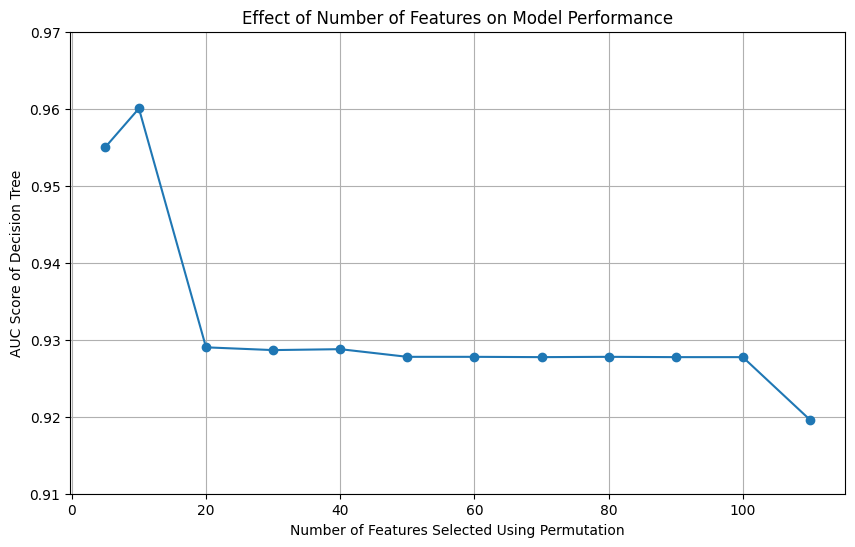

In [219]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(feature_counts_dt_perm, auc_scores_dt_perm, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using Permutation')
plt.ylabel('AUC Score of Decision Tree')
plt.title('Effect of Number of Features on Model Performance')

Permutation for Decision Tree identified the top 10 features as optimal, achieving an AUC score of 0.960, then similarity to RFE, performance experienced a significant drop, as increasing feature count beyond 20 resulted in relatively stable AUC scores around 0.928, with marginal performance decline at 110 features (AUC: 0.920).

## 3.2. CatBoost:

### 3.2.1. Best model performance:

#### 3.2.1.1. Hyperparameters Optimisation:

In [220]:
#record execution time
start = timer()

#define the objective function for Optuna
def objective_catboost(trial_cb):
    #suggest values for the hyperparameters
    depth = trial_cb.suggest_int("depth", 6, 10, step=2)
    learning_rate = trial_cb.suggest_float("learning_rate", 0.05, 0.1, step=0.05)
    iterations = trial_cb.suggest_int("iterations", 100, 300, step=100)

    #set up the CatBoostClassifier with the suggested hyperparameters
    catboost_classifier = CatBoostClassifier(
        random_state=7,
        auto_class_weights="Balanced",
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        verbose=0
    )

    #perform cross-validation and return the mean AUC score
    cv_cb = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    scores_cb = cross_val_score(
        catboost_classifier, Xtrain, ytrain, cv=cv_cb, scoring="roc_auc", n_jobs=-1
    )
    return scores_cb.mean()

#optimise the objective function
study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=20, show_progress_bar=True)

# Print execution time
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

[I 2024-12-07 02:09:02,148] A new study created in memory with name: no-name-60b2aa63-22dd-4eeb-82ab-adc50fb76477
Best trial: 0. Best value: 0.985905:   5%|██▎                                           | 1/20 [01:24<26:38, 84.11s/it]

[I 2024-12-07 02:10:26,362] Trial 0 finished with value: 0.9859052595995322 and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  10%|████▌                                         | 2/20 [01:38<12:52, 42.93s/it]

[I 2024-12-07 02:10:40,468] Trial 1 finished with value: 0.9762020296494184 and parameters: {'depth': 6, 'learning_rate': 0.05, 'iterations': 100}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  15%|██████▉                                       | 3/20 [01:58<09:11, 32.42s/it]

[I 2024-12-07 02:11:00,368] Trial 2 finished with value: 0.9847781719414543 and parameters: {'depth': 6, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  20%|█████████▏                                    | 4/20 [02:08<06:22, 23.90s/it]

[I 2024-12-07 02:11:11,216] Trial 3 finished with value: 0.9813959206409901 and parameters: {'depth': 6, 'learning_rate': 0.1, 'iterations': 100}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  25%|███████████▌                                  | 5/20 [02:19<04:48, 19.20s/it]

[I 2024-12-07 02:11:22,091] Trial 4 finished with value: 0.9762020296494184 and parameters: {'depth': 6, 'learning_rate': 0.05, 'iterations': 100}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  30%|█████████████▊                                | 6/20 [03:28<08:22, 35.92s/it]

[I 2024-12-07 02:12:30,475] Trial 5 finished with value: 0.9857007994658579 and parameters: {'depth': 10, 'learning_rate': 0.05, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  35%|████████████████                              | 7/20 [03:52<06:56, 32.06s/it]

[I 2024-12-07 02:12:54,590] Trial 6 finished with value: 0.9856622053893147 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  40%|██████████████████▍                           | 8/20 [04:28<06:39, 33.33s/it]

[I 2024-12-07 02:13:30,631] Trial 7 finished with value: 0.9852296558759408 and parameters: {'depth': 8, 'learning_rate': 0.05, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  45%|████████████████████▋                         | 9/20 [04:57<05:52, 32.01s/it]

[I 2024-12-07 02:13:59,736] Trial 8 finished with value: 0.9853423833141187 and parameters: {'depth': 6, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  50%|██████████████████████▌                      | 10/20 [06:06<07:15, 43.53s/it]

[I 2024-12-07 02:15:09,061] Trial 9 finished with value: 0.9859052595995322 and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  55%|████████████████████████▊                    | 11/20 [06:51<06:36, 44.01s/it]

[I 2024-12-07 02:15:54,147] Trial 10 finished with value: 0.9857977095825954 and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  60%|███████████████████████████                  | 12/20 [07:59<06:49, 51.23s/it]

[I 2024-12-07 02:17:01,911] Trial 11 finished with value: 0.9859052595995322 and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 0. Best value: 0.985905:  65%|█████████████████████████████▎               | 13/20 [09:09<06:37, 56.77s/it]

[I 2024-12-07 02:18:11,411] Trial 12 finished with value: 0.9859052595995322 and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 0 with value: 0.9859052595995322.


Best trial: 13. Best value: 0.985927:  70%|██████████████████████████████▊             | 14/20 [09:45<05:03, 50.55s/it]

[I 2024-12-07 02:18:47,598] Trial 13 finished with value: 0.9859269285818206 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927:  75%|█████████████████████████████████           | 15/20 [10:09<03:33, 42.71s/it]

[I 2024-12-07 02:19:12,114] Trial 14 finished with value: 0.9856622053893147 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927:  80%|███████████████████████████████████▏        | 16/20 [10:45<02:42, 40.64s/it]

[I 2024-12-07 02:19:47,975] Trial 15 finished with value: 0.9859269285818206 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927:  85%|█████████████████████████████████████▍      | 17/20 [11:10<01:47, 35.85s/it]

[I 2024-12-07 02:20:12,664] Trial 16 finished with value: 0.9856622053893147 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927:  90%|███████████████████████████████████████▌    | 18/20 [11:46<01:11, 35.97s/it]

[I 2024-12-07 02:20:48,907] Trial 17 finished with value: 0.9852296558759408 and parameters: {'depth': 8, 'learning_rate': 0.05, 'iterations': 300}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927:  95%|█████████████████████████████████████████▊  | 19/20 [12:22<00:36, 36.01s/it]

[I 2024-12-07 02:21:25,011] Trial 18 finished with value: 0.9859269285818206 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 300}. Best is trial 13 with value: 0.9859269285818206.


Best trial: 13. Best value: 0.985927: 100%|████████████████████████████████████████████| 20/20 [12:47<00:00, 38.36s/it]

[I 2024-12-07 02:21:49,500] Trial 19 finished with value: 0.9856622053893147 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 13 with value: 0.9859269285818206.
Execution time HH:MM:SS: 0:12:47.365429


In [221]:
#print the best parameters 
print("Best parameters:", study_cb.best_params)

Best parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 300}


In [222]:
#print the best AUC score 
print("Best AUC score:", study_cb.best_value)

Best AUC score: 0.9859269285818206


In [223]:
#record execution time for model training with best parameters
start = timer()

#set up the best CatBoost model using the best parameters from Optuna
best_cb_model = CatBoostClassifier(
    random_state=7,
    auto_class_weights="Balanced",
    depth=study_cb.best_params['depth'],
    learning_rate=study_cb.best_params['learning_rate'],
    iterations=study_cb.best_params['iterations'],
    verbose=0
)

#fit the best model on the training data
best_cb_model.fit(Xtrain, ytrain)

#print training execution time
print("Model training time HH:MM:SS:", timedelta(seconds=timer() - start))

Model training time HH:MM:SS: 0:00:09.214986


#### 3.2.1.2. Training set prediction:

In [224]:
#record prediction time
start = timer()

#predict on the training data
yhat_cb = best_cb_model.predict(Xtrain)

#print prediction time
print("Prediction time HH:MM:SS:", timedelta(seconds=timer() - start))

Prediction time HH:MM:SS: 0:00:00.116866


In [225]:
#evaluate the performance
p, r, f, s = precision_recall_fscore_support(ytrain, yhat_cb, average="macro", zero_division=0)
auc_score = roc_auc_score(ytrain, yhat_cb)

print("Catboost:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Catboost:
Precision: 0.792
Recall: 0.976
F score: 0.856
AUC Score: 0.976


#### 3.2.1.3. Testing set prediction:

In [226]:
#record prediction time
start = timer()

#predict on the training data
yhat_cb = best_cb_model.predict(Xtest)

#print prediction time
print("Prediction time HH:MM:SS:", timedelta(seconds=timer() - start))

Prediction time HH:MM:SS: 0:00:00.026002


In [227]:
#evaluate the performance
p, r, f, s = precision_recall_fscore_support(ytest, yhat_cb, average="macro", zero_division=0)
auc_score = roc_auc_score(ytest, yhat_cb)

print("Catboost:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")
print(f"AUC Score: {auc_score:.3f}")

Catboost:
Precision: 0.761
Recall: 0.933
F score: 0.819
AUC Score: 0.933


CatBoost also achieved a training AUC score of 0.976 and a testing AUC score of 0.933, indicating strong model performance with minimal overfitting.

### 3.2.2. Feature selection methods:

#### 3.2.2.1. RFE:

In [228]:
#start the timer
start_time = time.time()

#define a function to evaluate model AUC score according to top 'n' features using RFE
def evaluate_rfe(model, X_train, X_test, y_train, y_test, num_features):
    #initialize RFE
    rfe_cb = RFE(estimator=model, n_features_to_select=num_features)
    
    #fit RFE
    rfe_cb.fit(X_train, y_train)
    
    #transform data to retain selected features
    Xtrain_rfe = rfe_cb.transform(X_train)
    Xtest_rfe = rfe_cb.transform(X_test)
    
    #fit the model with the reduced feature set
    model.fit(Xtrain_rfe, y_train)
    
    #predict and calculate the AUC score
    y_pred_rfe = model.predict(Xtest_rfe)
    auc_cb = roc_auc_score(y_test, y_pred_rfe)
    
    return auc_cb, rfe_cb

#set up lists to store feature counts, AUC scores, and the best features
feature_counts_cb_rfe = []
auc_scores_cb_rfe = []
best_top_features_cb_rfe = None  
best_auc_cb_rfe = -1  

#track progress of the program
print("Starting RFE and model evaluation process...")

#initial evaluation with top 5 features
initial_num_features = 5
auc_score_cb_rfe, rfe_cb_rfe = evaluate_rfe(best_cb_model, Xtrain, Xtest, ytrain, ytest, initial_num_features)
auc_scores_cb_rfe.append(auc_score_cb_rfe)
feature_counts_cb_rfe.append(initial_num_features)

#check for the best AUC score and update best_top_features_cb_rfe if found
if auc_score_cb_rfe > best_auc_cb_rfe:
    best_auc_cb_rfe = auc_score_cb_rfe
    best_top_features_cb_rfe = rfe_cb_rfe.support_  #store the selected features for the best AUC score  

print(f"Top {initial_num_features} Features, AUC Score: {auc_score_cb_rfe:.3f}")

#define the range of increments being 10
feature_steps = range(10, Xtrain.shape[1] + 1, 10)

#loop over feature steps, in increments of 10
for num_features in tqdm(feature_steps, desc="Evaluating Features"):
    auc_score_cb_rfe, rfe_cb_rfe = evaluate_rfe(best_cb_model, Xtrain, Xtest, ytrain, ytest, num_features)
    
    #store results
    auc_scores_cb_rfe.append(auc_score_cb_rfe)
    feature_counts_cb_rfe.append(num_features)

    #check for the best AUC score and update best_top_features_cb_rfe if found
    if auc_score_cb_rfe > best_auc_cb_rfe:
        best_auc_cb_rfe = auc_score_cb_rfe
        best_top_features_cb_rfe = rfe_cb_rfe.support_  #update with the best features corresponding to the best AUC score  
    
    print(f"Top {num_features} Features, AUC Score: {auc_score_cb_rfe:.3f}")

#calculate the total execution time
execution_time = time.time() - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

Starting RFE and model evaluation process...
Top 5 Features, AUC Score: 0.958


Evaluating Features:   9%|█████▎                                                     | 1/11 [14:41<2:26:51, 881.16s/it]

Top 10 Features, AUC Score: 0.966


Evaluating Features:  18%|██████████▋                                                | 2/11 [28:02<2:05:07, 834.14s/it]

Top 20 Features, AUC Score: 0.934


Evaluating Features:  27%|████████████████                                           | 3/11 [40:04<1:44:23, 782.91s/it]

Top 30 Features, AUC Score: 0.930


Evaluating Features:  36%|█████████████████████▍                                     | 4/11 [50:39<1:24:31, 724.47s/it]

Top 40 Features, AUC Score: 0.928


Evaluating Features:  45%|██████████████████████████▊                                | 5/11 [59:44<1:05:59, 659.98s/it]

Top 50 Features, AUC Score: 0.930


Evaluating Features:  55%|████████████████████████████████▏                          | 6/11 [1:07:22<49:16, 591.33s/it]

Top 60 Features, AUC Score: 0.929


Evaluating Features:  64%|█████████████████████████████████████▌                     | 7/11 [1:13:31<34:34, 518.66s/it]

Top 70 Features, AUC Score: 0.930


Evaluating Features:  73%|██████████████████████████████████████████▉                | 8/11 [1:18:15<22:11, 443.78s/it]

Top 80 Features, AUC Score: 0.928


Evaluating Features:  82%|████████████████████████████████████████████████▎          | 9/11 [1:21:31<12:12, 366.23s/it]

Top 90 Features, AUC Score: 0.930


Evaluating Features:  91%|████████████████████████████████████████████████████▋     | 10/11 [1:23:18<04:46, 286.18s/it]

Top 100 Features, AUC Score: 0.933


Evaluating Features: 100%|██████████████████████████████████████████████████████████| 11/11 [1:23:35<00:00, 456.00s/it]

Top 110 Features, AUC Score: 0.933
Execution Time: 5941.21 seconds


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

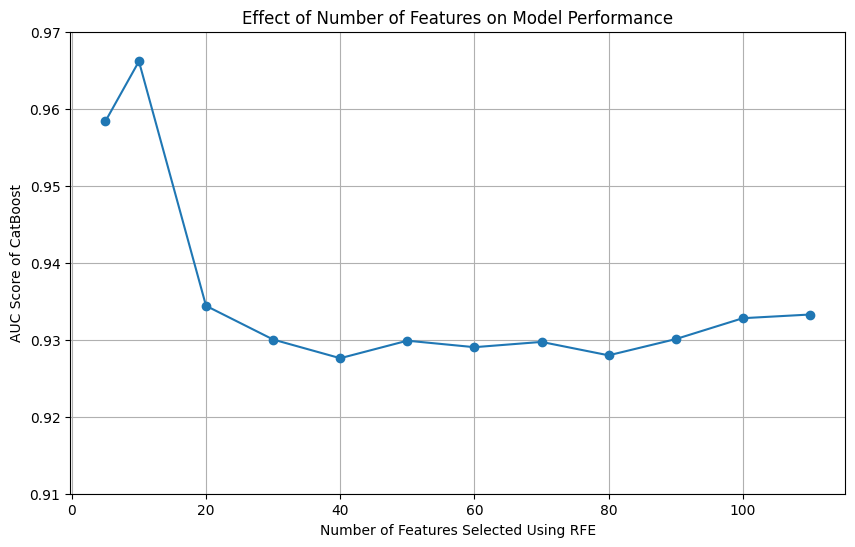

In [229]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(feature_counts_cb_rfe, auc_scores_cb_rfe, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using RFE')
plt.ylabel('AUC Score of CatBoost')
plt.title('Effect of Number of Features on Model Performance')

RFE applied to CatBoost also identified the top 10 features to contribute to the highest model performance with AUC score of 0.966, it also experience a sharp drop after 10 features. Beyond 20 features, AUC scores began to stabilise, with marginal differences observed as more features were included.

#### 3.2.2.2. Permutation:

In [230]:
#initialise Dask for parallel processing
client = Client()

#convert Xtrain and Xtest into Dask DataFrames
Xtrain_dd = dd.from_pandas(Xtrain, npartitions=5)
Xtest_dd = dd.from_pandas(Xtest, npartitions=5)

#start the timer
start_time = time.time()

#define a function to compute the permutation importance
def compute_importance(model, X, y):
    #convert Dask DataFrame to pandas DataFrame before passing to the model
    X_pd = X.compute()  #ensure X is in pandas format
    result = permutation_importance(model, X_pd, y, n_repeats=10, random_state=7)
    return result.importances_mean

#calculate permutation importance in parallel using Dask
result_cb_perm = compute_importance(best_cb_model, Xtest_dd, ytest)

#create a DataFrame for feature importances
importances_cb_perm = pd.DataFrame({'feature': Xtest.columns, 'importance': result_cb_perm}).sort_values(by='importance', ascending=False)

#define a function to evaluate CB AUC score according to top 'n' features
def evaluate_with_top_n_features(model, X_train, X_test, y_train, y_test, top_n_features):
    #ensure top_n_features are selected correctly
    top_features_cb_perm = importances_cb_perm['feature'].head(top_n_features).values
    Xtrain_cb_perm = X_train[top_features_cb_perm]
    Xtest_cb_perm = X_test[top_features_cb_perm]

    #fit the model with the top 'n' features
    model.fit(Xtrain_cb_perm, y_train)
    y_pred_cb_perm = model.predict(Xtest_cb_perm)

    #calculate the AUC score  
    auc_perm = roc_auc_score(y_test, y_pred_cb_perm)
    return auc_perm, top_features_cb_perm

#set up lists to store feature counts, AUC scores, and best estimator
feature_counts_cb_perm = []
auc_scores_cb_perm = []
best_auc_cb_perm = -1
best_top_features_cb_perm = None

#track the progress of the program
print("Starting permutation and model evaluation process...")

#conduct initial evaluation with top 5 features
initial_top_n = 5
auc_score_cb_perm, top_features_cb_perm = evaluate_with_top_n_features(best_cb_model, Xtrain, Xtest, ytrain, ytest, initial_top_n)
auc_scores_cb_perm.append(auc_score_cb_perm)
feature_counts_cb_perm.append(initial_top_n)

#check for the best AUC score and update best_auc_cb_perm and best_top_features_cb_perm if found 
if auc_score_cb_perm > best_auc_cb_perm:
    best_auc_cb_perm = auc_score_cb_perm
    best_top_features_cb_perm = top_features_cb_perm

print(f"Top {initial_top_n} Features, AUC Score: {auc_score_cb_perm:.3f}")

#define the range of feature increments being 5
for top_n in tqdm(range(10, len(importances_cb_perm) + 1, 10)):
    auc_score_cb_perm, top_features_cb_perm = evaluate_with_top_n_features(best_cb_model, Xtrain, Xtest, ytrain, ytest, top_n)
    auc_scores_cb_perm.append(auc_score_cb_perm)
    feature_counts_cb_perm.append(top_n)

    #check for the best AUC score and update best_auc_cb_perm and best_top_features_cb_perm if found
    if auc_score_cb_perm > best_auc_cb_perm:
        best_auc_cb_perm = auc_score_cb_perm
        best_top_features_cb_perm = top_features_cb_perm

    print(f"Top {top_n} Features, AUC Score: {auc_score_cb_perm:.3f}")

#calculate the total execution time
execution_time = time.time() - start_time
print(f"Total execution time: {execution_time:.3f} seconds")

#close Dask client
client.close()

Starting permutation and model evaluation process...
Top 5 Features, AUC Score: 0.959


  9%|███████▌                                                                           | 1/11 [00:12<02:02, 12.25s/it]

Top 10 Features, AUC Score: 0.966


 18%|███████████████                                                                    | 2/11 [00:25<01:54, 12.75s/it]

Top 20 Features, AUC Score: 0.964


 27%|██████████████████████▋                                                            | 3/11 [00:38<01:42, 12.77s/it]

Top 30 Features, AUC Score: 0.953


 36%|██████████████████████████████▏                                                    | 4/11 [00:50<01:29, 12.78s/it]

Top 40 Features, AUC Score: 0.938


 45%|█████████████████████████████████████▋                                             | 5/11 [01:03<01:17, 12.87s/it]

Top 50 Features, AUC Score: 0.933


 55%|█████████████████████████████████████████████▎                                     | 6/11 [01:16<01:04, 12.82s/it]

Top 60 Features, AUC Score: 0.945


 64%|████████████████████████████████████████████████████▊                              | 7/11 [01:29<00:51, 12.97s/it]

Top 70 Features, AUC Score: 0.950


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [01:43<00:39, 13.09s/it]

Top 80 Features, AUC Score: 0.943


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [01:56<00:26, 13.15s/it]

Top 90 Features, AUC Score: 0.936


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [02:09<00:13, 13.17s/it]

Top 100 Features, AUC Score: 0.937


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:24<00:00, 13.12s/it]

Top 110 Features, AUC Score: 0.933
Total execution time: 204.703 seconds


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

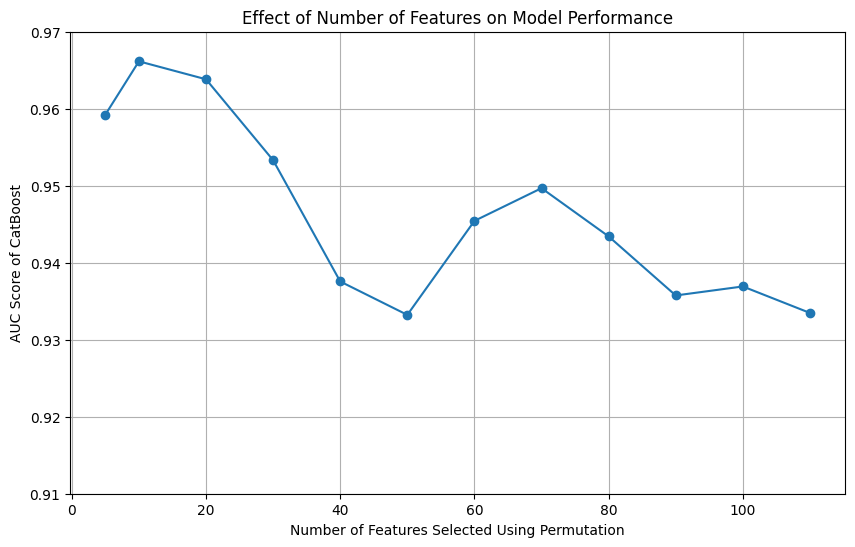

In [231]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(feature_counts_cb_perm, auc_scores_cb_perm, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using Permutation')
plt.ylabel('AUC Score of CatBoost')
plt.title('Effect of Number of Features on Model Performance')

Permutation on CatBoost revealed the top 10 features achieved the highest AUC score of 0.966 too. Beyond 20 features, AUC scores steadily declined until reaching 50 features. Interestingly, a secondary peak was observed at 70 features with an AUC score of 0.950, followed by another gradual decline.

## 3.3. Keras Neural Networks:

### 3.3.1. Best model performance:

#### 3.3.1.1. Hyperparameter tuning:

In [4]:
#define the objective function for Optuna optimization
def objective(trial):
    #hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)  #learning rate range 
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])   #batch sizes 
    num_neurons = trial.suggest_int('num_neurons', 16, 64, step=16)       #number of neurons per layer 
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)          #dropout rate 

    #build the Keras model 
    model = Sequential([
        Dense(num_neurons, input_dim=110, activation='relu'),              #first hidden layer 
        Dropout(dropout_rate),                                             #dropout for regularisation 
        Dense(num_neurons, activation='relu'),                             #second hidden layer 
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')                                     #output layer 
    ])

    #compile the model with binary crossentropy and AUC
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['AUC'])

    #train the model 
    model.fit(Xtrain, ytrain, epochs=5, batch_size=batch_size, validation_data=(Xtest, ytest), verbose=0)

    #predict on testing set 
    y_pred = model.predict(Xtest)

    #calculate the AUC score 
    auc = roc_auc_score(ytest, y_pred)
    
    return auc  

#create an Optuna study to maximise the AUC score 
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=20)  #perform 20 trials for tuning simplicity

#print the best hyperparamaters and AUC score found 
print(f"Best AUC: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")

[I 2024-12-06 07:51:33,269] A new study created in memory with name: no-name-ae436acf-d2fd-434f-849b-eaac90da1ff0


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


[I 2024-12-06 07:51:59,528] Trial 0 finished with value: 0.9488754020539172 and parameters: {'learning_rate': 0.00019497312646515416, 'batch_size': 32, 'num_neurons': 16, 'dropout_rate': 0.3433015190424451}. Best is trial 0 with value: 0.9488754020539172.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:52:10,047] Trial 1 finished with value: 0.9468492575203801 and parameters: {'learning_rate': 0.0002547978173483504, 'batch_size': 128, 'num_neurons': 32, 'dropout_rate': 0.2656651237584749}. Best is trial 0 with value: 0.9488754020539172.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:52:45,877] Trial 2 finished with value: 0.9513742440183199 and parameters: {'learning_rate': 0.00019865585695964284, 'batch_size': 32, 'num_neurons': 64, 'dropout_rate': 0.31787252277952893}. Best is trial 2 with value: 0.9513742440183199.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:53:03,954] Trial 3 finished with value: 0.9489734507388703 and parameters: {'learning_rate': 0.00031077958320862816, 'batch_size': 64, 'num_neurons': 32, 'dropout_rate': 0.34308618311114125}. Best is trial 2 with value: 0.9513742440183199.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:53:34,344] Trial 4 finished with value: 0.9494460646173836 and parameters: {'learning_rate': 0.00013869295815007547, 'batch_size': 32, 'num_neurons': 48, 'dropout_rate': 0.46513289181570683}. Best is trial 2 with value: 0.9513742440183199.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-12-06 07:53:52,218] Trial 5 finished with value: 0.9456707098206767 and parameters: {'learning_rate': 0.0001059102613323375, 'batch_size': 64, 'num_neurons': 32, 'dropout_rate': 0.22872035477563235}. Best is trial 2 with value: 0.9513742440183199.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:54:04,582] Trial 6 finished with value: 0.9433666283885492 and parameters: {'learning_rate': 0.00010625972462812783, 'batch_size': 128, 'num_neurons': 16, 'dropout_rate': 0.1830327009421817}. Best is trial 2 with value: 0.9513742440183199.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


[I 2024-12-06 07:54:14,764] Trial 7 finished with value: 0.9513950067777668 and parameters: {'learning_rate': 0.0009518499716424716, 'batch_size': 128, 'num_neurons': 16, 'dropout_rate': 0.11540763515373582}. Best is trial 7 with value: 0.9513950067777668.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


[I 2024-12-06 07:54:33,133] Trial 8 finished with value: 0.9532512893798945 and parameters: {'learning_rate': 0.004495821995958754, 'batch_size': 64, 'num_neurons': 32, 'dropout_rate': 0.42199028189782684}. Best is trial 8 with value: 0.9532512893798945.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


[I 2024-12-06 07:54:42,493] Trial 9 finished with value: 0.954416635807998 and parameters: {'learning_rate': 0.0024725360299718605, 'batch_size': 128, 'num_neurons': 32, 'dropout_rate': 0.10887816616705037}. Best is trial 9 with value: 0.954416635807998.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-06 07:54:54,155] Trial 10 finished with value: 0.9554237758577819 and parameters: {'learning_rate': 0.007016761230974652, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.10033514132969834}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:55:08,167] Trial 11 finished with value: 0.9553177896993986 and parameters: {'learning_rate': 0.009046890072540371, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.10356506401658036}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-12-06 07:55:21,115] Trial 12 finished with value: 0.9537952151907534 and parameters: {'learning_rate': 0.00985366453487616, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.17679137646589482}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:55:30,205] Trial 13 finished with value: 0.9541224062007878 and parameters: {'learning_rate': 0.009843035089860886, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.16123467580153705}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


[I 2024-12-06 07:55:40,674] Trial 14 finished with value: 0.9552510731464078 and parameters: {'learning_rate': 0.004323975148126022, 'batch_size': 128, 'num_neurons': 48, 'dropout_rate': 0.11307461376678324}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


[I 2024-12-06 07:55:49,792] Trial 15 finished with value: 0.9527907488162303 and parameters: {'learning_rate': 0.001010775049238403, 'batch_size': 128, 'num_neurons': 48, 'dropout_rate': 0.23358225428762758}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


[I 2024-12-06 07:56:03,666] Trial 16 finished with value: 0.9521444295981198 and parameters: {'learning_rate': 0.00476944991093204, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.15960666106001142}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-12-06 07:56:17,953] Trial 17 finished with value: 0.9532271845263719 and parameters: {'learning_rate': 0.0019383949080395504, 'batch_size': 128, 'num_neurons': 48, 'dropout_rate': 0.4010935851952556}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


[I 2024-12-06 07:56:49,159] Trial 18 finished with value: 0.9518491973626867 and parameters: {'learning_rate': 0.006414087186207437, 'batch_size': 32, 'num_neurons': 64, 'dropout_rate': 0.2059842698953071}. Best is trial 10 with value: 0.9554237758577819.


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2024-12-06 07:57:16,537] Trial 19 finished with value: 0.9534564939561571 and parameters: {'learning_rate': 0.0021884455633990013, 'batch_size': 64, 'num_neurons': 64, 'dropout_rate': 0.27887092157672055}. Best is trial 10 with value: 0.9554237758577819.


Best AUC: 0.9554
Best Hyperparameters: {'learning_rate': 0.007016761230974652, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.10033514132969834}


#### 3.3.1.2. Testing set prediction:

In [5]:
#get the best paramaters 
best_params = study.best_params

#retrain the model with the best parameters
model = Sequential([
    Dense(best_params['num_neurons'], input_dim=110, activation='relu'),      
    Dropout(best_params['dropout_rate']),                                     
    Dense(best_params['num_neurons'], activation='relu'),                     
    Dropout(best_params['dropout_rate']),                                     
    Dense(1, activation='sigmoid')                                            
])

#compile the model with best params found 
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_params['learning_rate']), metrics=['AUC'])

#train the model with best batch size param found 
model.fit(Xtrain, ytrain, epochs=5, batch_size=best_params['batch_size'], validation_data=(Xtest, ytest), verbose=0)

#predict on Xtest 
y_pred = model.predict(Xtest)

#convert probabilities to binary labels 
y_pred_labels = (y_pred > 0.5).astype(int)  

#evaluate the AUC score 
auc = roc_auc_score(ytest, y_pred)
print(f"AUC on Xtest with best parameters: {auc:.4f}")

Best AUC: 0.9554
Best Hyperparameters: {'learning_rate': 0.007016761230974652, 'batch_size': 128, 'num_neurons': 64, 'dropout_rate': 0.10033514132969834}
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC on Xtest with best parameters: 0.9582


### 3.3.2. Feature methods selection:

#### 3.3.2.1. RFE:

The following code addresses feature selection for a Keras MLP by using permutation importance, as Keras does not provide inherent feature importance. A custom KerasRFE class is defined that combines RFE with permutation importance to identify the most impactful features. The model is retrained with different subsets of features, and the AUC score is calculated for each subset. The best features and model, which achieve the highest AUC, are saved to conserve reproductibility. 

In [183]:
#set a random seed for reproducibility
def set_seed(seed_value=7):
    np.random.seed(seed_value)
    random.seed(seed_value)

set_seed()

#function to silence model predictions
def silent_predict(model, X):
    tf.get_logger().setLevel('ERROR')  # Disable logs at this point
    return model.predict(X, verbose=0)

#define a function for model building
def create_model(best_params, input_dim):
    model = Sequential([
        Dense(best_params['num_neurons'], input_dim=input_dim, activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(best_params['num_neurons'], activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_params['learning_rate']), metrics=['AUC'])
    return model

#wrap the Keras model using KerasClassifier
def wrap_model(best_params, input_dim):
    model = KerasClassifier(model=create_model(best_params, input_dim), epochs=10, batch_size=best_params['batch_size'], verbose=0)
    return model

class KerasRFE(RFE):
    def __init__(self, estimator, n_features_to_select, X_train, y_train, **kwargs):
        super(KerasRFE, self).__init__(estimator=estimator, n_features_to_select=n_features_to_select, **kwargs)
        self.X_train = X_train
        self.y_train = y_train

    def _fit(self, X, y):
        self.estimator.fit(X, y)

#save the model and best features when a better AUC score is found
def save_model_and_features(model_keras, best_top_features):
    #save the Keras model (architecture + weights)
    keras_model = model_keras.model  #access the actual Keras model from the wrapper
    keras_model.save('best_model.h5')  #save the model
    
    #save the top features using joblib
    joblib.dump(best_top_features, 'best_top_features_keras_rfe.pkl')

#function to compute permutation importance and sort features
def compute_permutation_importance(model, X, y, random_state=7):
    np.random.seed(random_state)  # Set random seed
    importances = []
    baseline_preds = silent_predict(model, X).flatten()
    baseline_auc = roc_auc_score(y, baseline_preds)
    
    for col in X.columns:
        X_permuted = X.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])  # Shuffle with controlled randomness
        permuted_preds = silent_predict(model, X_permuted).flatten()
        permuted_auc = roc_auc_score(y, permuted_preds)
        importance = baseline_auc - permuted_auc
        importances.append((col, importance))
    
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances, baseline_auc

#function to get top N features based on permutation importance
def get_top_n_features(importances, n):
    #select the top N features based on their importance score
    top_features = [feature[0] for feature in importances[:n]]
    return top_features

#evaluating top features selected by permutation importance
def evaluate_auc_with_selected_features(best_params, X_train, y_train, X_test, y_test, selected_features):
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    #reinitialise the model for the new input dimension
    model = wrap_model(best_params, X_train_selected.shape[1])
    model.fit(X_train_selected, y_train)
    y_pred_selected = model.predict_proba(X_test_selected)[:, 1]
    
    #calculate AUC score
    auc_score_selected = roc_auc_score(y_test, y_pred_selected)
    return auc_score_selected, selected_features

#start timer and track execution time
start_time = time.time()

#track progress of the RFE process
print("Starting RFE and model evaluation process...")

#set up lists to store top features and AUC scores
features_counts_keras_rfe = []  #will count top 10, 20, 30 features etc.
auc_scores_keras_rfe = []
best_auc_score = 0  #initialise with a low score for comparison
best_top_features_keras_rfe = []  #store the best features

#set up RFE with Keras and Permutation Feature Importance
keras_rfe = KerasRFE(estimator=wrap_model(best_params, Xtrain.shape[1]), n_features_to_select=5, X_train=Xtrain, y_train=ytrain)

#perform RFE with the Keras model
keras_rfe.fit(Xtrain, ytrain)

#get permutation importance and sort features
importances, baseline_auc = compute_permutation_importance(keras_rfe.estimator, Xtrain, ytrain)

#evaluate top 5 features based on permutation importance
top_5_features = get_top_n_features(importances, 5)
auc_score_top_5, top_features = evaluate_auc_with_selected_features(best_params, Xtrain, ytrain, Xtest, ytest, top_5_features)
auc_scores_keras_rfe.append(auc_score_top_5)
features_counts_keras_rfe.append(5)

if auc_score_top_5 > best_auc_score:
    best_auc_score = auc_score_top_5
    best_top_features_keras_rfe = top_features

print(f"Top 5 Features, AUC Score: {auc_score_top_5:.3f}")

#save the model and best features only once when the best AUC score is achieved
if auc_score_top_5 > best_auc_score:
    best_auc_score = auc_score_top_5
    best_top_features_keras_rfe = top_features
    # Save the model to disk after training it once
    model_keras = wrap_model(best_params, Xtrain[top_features].shape[1])  #use top_features instead of selected_features
    model_keras.fit(Xtrain[top_features], ytrain)
    save_model_and_features(model_keras, best_top_features_keras_rfe)

#evaluate in increments of 10 features for broader selection
for top_n in tqdm(range(10, len(Xtrain.columns) + 1, 10)):
    top_features = get_top_n_features(importances, top_n)
    auc_score_top_n, top_features = evaluate_auc_with_selected_features(best_params, Xtrain, ytrain, Xtest, ytest, top_features)
    
    auc_scores_keras_rfe.append(auc_score_top_n)
    features_counts_keras_rfe.append(top_n)  #track the top_n in each iteration
    
    #track best AUC score and corresponding features
    if auc_score_top_n > best_auc_score:
        best_auc_score = auc_score_top_n
        best_top_features_keras_rfe = top_features
        # Save the best model to disk only once (after training it)
        model_keras = wrap_model(best_params, Xtrain[top_features].shape[1])  #use top_features instead of selected_features
        model_keras.fit(Xtrain[top_features], ytrain)
        save_model_and_features(model_keras, best_top_features_keras_rfe)

    print(f"Top {top_n} Features, AUC Score: {auc_score_top_n:.3f}")

#calculate total execution time
execution_time = time.time() - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

Starting RFE and model evaluation process...
Top 5 Features, AUC Score: 0.942


  9%|███████▌                                                                           | 1/11 [00:43<07:19, 43.93s/it]

Top 10 Features, AUC Score: 0.958


 18%|███████████████                                                                    | 2/11 [01:25<06:24, 42.77s/it]

Top 20 Features, AUC Score: 0.968


 27%|██████████████████████▋                                                            | 3/11 [01:46<04:21, 32.67s/it]

Top 30 Features, AUC Score: 0.964


 36%|██████████████████████████████▏                                                    | 4/11 [02:08<03:18, 28.29s/it]

Top 40 Features, AUC Score: 0.959


 45%|█████████████████████████████████████▋                                             | 5/11 [02:31<02:38, 26.35s/it]

Top 50 Features, AUC Score: 0.957


 55%|█████████████████████████████████████████████▎                                     | 6/11 [02:51<02:02, 24.44s/it]

Top 60 Features, AUC Score: 0.953


 64%|████████████████████████████████████████████████████▊                              | 7/11 [03:14<01:35, 23.80s/it]

Top 70 Features, AUC Score: 0.956


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [03:38<01:11, 23.83s/it]

Top 80 Features, AUC Score: 0.955


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [03:59<00:46, 23.00s/it]

Top 90 Features, AUC Score: 0.956


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [04:18<00:21, 21.89s/it]

Top 100 Features, AUC Score: 0.948


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:38<00:00, 25.31s/it]

Top 110 Features, AUC Score: 0.955
Total execution time: 756.05 seconds


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

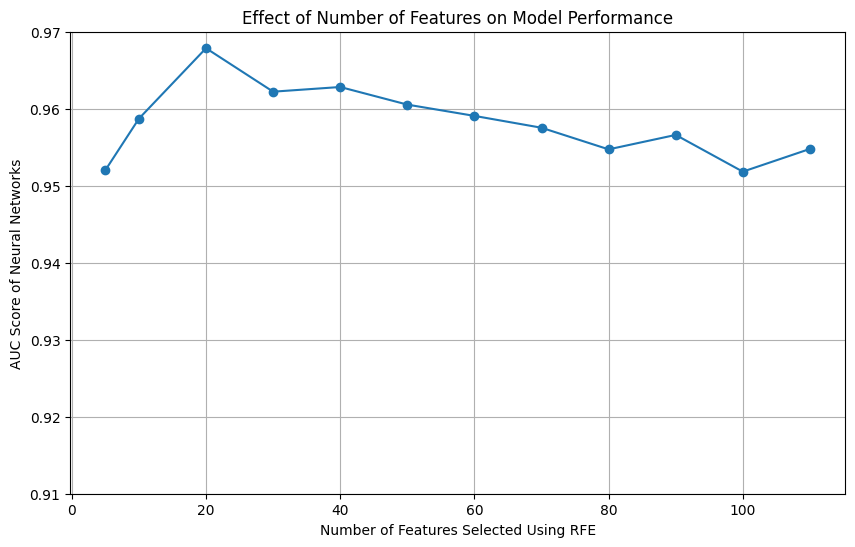

In [75]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(features_counts_keras_rfe, auc_scores_keras_rfe, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using RFE')
plt.ylabel('AUC Score of Neural Networks')
plt.title('Effect of Number of Features on Model Performance')

RFE applied to Keras MLP model showed that the top 20 features achieved the highest AUC score of 0.968, as opposed to Catboost and Decision Tree top 10 features. However, after the peak, the scores declined gradually until 100 features, where the AUC reached 0.948. A slight recovery in performance occurred at 110 features with an AUC score of 0.955. But overall the AUC scores remained relatively high.

#### 3.3.2.2. Permutation:

In [70]:
#start the timer
start_time = time.time()

#function to silence model predictions
def silent_predict(model, X):
    tf.get_logger().setLevel('ERROR')  # Disable logs at this point
    return model.predict(X, verbose=0)

#set a random seed for reproducibility
np.random.seed(7)

#define a function to compute permutation importance for all features at once
def compute_permutation_importance(model, X, y, random_state=7):
    importances = []
    baseline_preds = silent_predict(model, X).flatten()  # Use silent_predict to avoid verbosity
    baseline_auc = roc_auc_score(y, baseline_preds)
    
    for col in X.columns:
        X_permuted = X.copy()
        np.random.seed(random_state)  # Ensure reproducibility
        X_permuted[col] = np.random.permutation(X_permuted[col])  # Permute the column
        permuted_preds = silent_predict(model, X_permuted).flatten()  # Use silent_predict to avoid verbosity
        permuted_auc = roc_auc_score(y, permuted_preds)
        importance = baseline_auc - permuted_auc
        importances.append((col, importance))
    
    #sort features by importance
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances, baseline_auc

#define a function for model creation
def create_model(best_params, input_dim):
    model = Sequential([
        Dense(best_params['num_neurons'], input_dim=input_dim, activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(best_params['num_neurons'], activation='relu'),
        Dropout(best_params['dropout_rate']),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_params['learning_rate']), metrics=['AUC'])
    return model

#define a function for AUC evaluation with selected features
def evaluate_auc_with_selected_features(best_params, X_train, y_train, X_test, y_test, selected_features):
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    #reinitialise the model for the new input dimension
    model = KerasClassifier(build_fn=create_model, 
                            best_params=best_params, 
                            input_dim=X_train_selected.shape[1], 
                            epochs=10, batch_size=best_params['batch_size'], 
                            verbose=0)  #ensure verbose is set to 0 here
    
    model.fit(X_train_selected, y_train)  #use verbose=0 to suppress output during training
    y_pred_selected = model.predict_proba(X_test_selected)[:, 1]
    
    #calculate AUC score
    auc_score_selected = roc_auc_score(y_test, y_pred_selected)
    return auc_score_selected

#initialise variables
feature_counts_keras_perm = []
auc_scores_keras_perm = []
best_auc_score_keras_perm = -1
best_features_keras_perm = []

#compute permutation importance for all features
print("Computing permutation importance for all features...")
feature_importances, auc_initial = compute_permutation_importance(model, Xtrain, ytrain)

#evaluate AUC score for top 5 features
top_5_features = [f[0] for f in feature_importances[:5]]
auc_score_top_5 = evaluate_auc_with_selected_features(best_params, Xtrain, ytrain, Xtest, ytest, top_5_features)
auc_scores_keras_perm.append(auc_score_top_5)
feature_counts_keras_perm.append(5)

if auc_score_top_5 > best_auc_score_keras_perm:
    best_auc_score_keras_perm = auc_score_top_5
    best_features_keras_perm = top_5_features

tqdm.write(f"Top 5 Features, AUC Score: {auc_score_top_5:.3f}")

#incrementally evaluate subsets of features
feature_steps = range(10, Xtrain.shape[1] + 1, 10)
for num_features in tqdm(feature_steps, desc="Evaluating Features"):  
    top_features = [f[0] for f in feature_importances[:num_features]]
    auc_score = evaluate_auc_with_selected_features(best_params, Xtrain, ytrain, Xtest, ytest, top_features)
    
    auc_scores_keras_perm.append(auc_score)
    feature_counts_keras_perm.append(num_features)
    
    if auc_score > best_auc_score_keras_perm:
        best_auc_score_keras_perm = auc_score
        best_features_keras_perm = top_features

    tqdm.write(f"Top {num_features} Features, AUC Score: {auc_score:.3f}")

#calculate total execution time
execution_time = time.time() - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

Computing permutation importance for all features...
Top 5 Features, AUC Score: 0.951


Evaluating Features:   9%|█████▋                                                        | 1/11 [00:21<03:38, 21.80s/it]

Top 10 Features, AUC Score: 0.959


Evaluating Features:  18%|███████████▎                                                  | 2/11 [00:41<03:03, 20.39s/it]

Top 20 Features, AUC Score: 0.966


Evaluating Features:  27%|████████████████▉                                             | 3/11 [01:01<02:42, 20.36s/it]

Top 30 Features, AUC Score: 0.962


Evaluating Features:  36%|██████████████████████▌                                       | 4/11 [01:24<02:28, 21.27s/it]

Top 40 Features, AUC Score: 0.962


Evaluating Features:  45%|████████████████████████████▏                                 | 5/11 [01:44<02:04, 20.75s/it]

Top 50 Features, AUC Score: 0.959


Evaluating Features:  55%|█████████████████████████████████▊                            | 6/11 [02:04<01:43, 20.71s/it]

Top 60 Features, AUC Score: 0.957


Evaluating Features:  64%|███████████████████████████████████████▍                      | 7/11 [02:22<01:19, 19.86s/it]

Top 70 Features, AUC Score: 0.958


Evaluating Features:  73%|█████████████████████████████████████████████                 | 8/11 [02:41<00:58, 19.40s/it]

Top 80 Features, AUC Score: 0.953


Evaluating Features:  82%|██████████████████████████████████████████████████▋           | 9/11 [03:00<00:38, 19.41s/it]

Top 90 Features, AUC Score: 0.956


Evaluating Features:  91%|███████████████████████████████████████████████████████▍     | 10/11 [03:19<00:19, 19.13s/it]

Top 100 Features, AUC Score: 0.955


Evaluating Features: 100%|█████████████████████████████████████████████████████████████| 11/11 [03:39<00:00, 19.97s/it]

Top 110 Features, AUC Score: 0.954
Total execution time: 439.45 seconds


Text(0.5, 1.0, 'Effect of Number of Features on Model Performance')

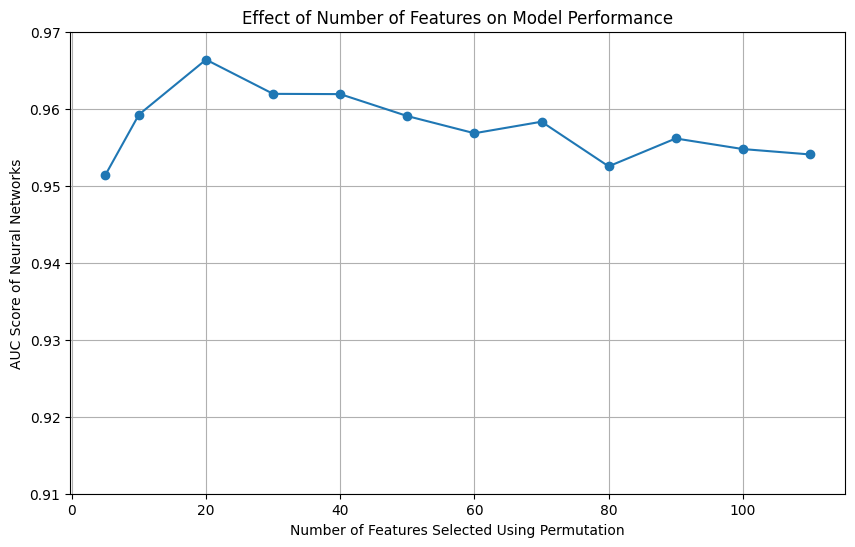

In [71]:
#plot the AUC scores & the number of features selected
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(feature_counts_keras_perm, auc_scores_keras_perm, marker='o')
plt.ylim(0.910, 0.970)
plt.xlabel('Number of Features Selected Using Permutation')
plt.ylabel('AUC Score of Neural Networks')
plt.title('Effect of Number of Features on Model Performance')

Permutation on Keras MLP model showed that the top 20 features achieved the highest AUC score of 0.966, similar to its RFE results. Afterward, the scores gradually declined until 80 features then rose again. The final score at 110 features was 0.954, showing a decrease from the peak, but nontheless maintained a relatively high AUC scores overall.

## 3.4. Machine Learning Models ROC Curve Visualisation

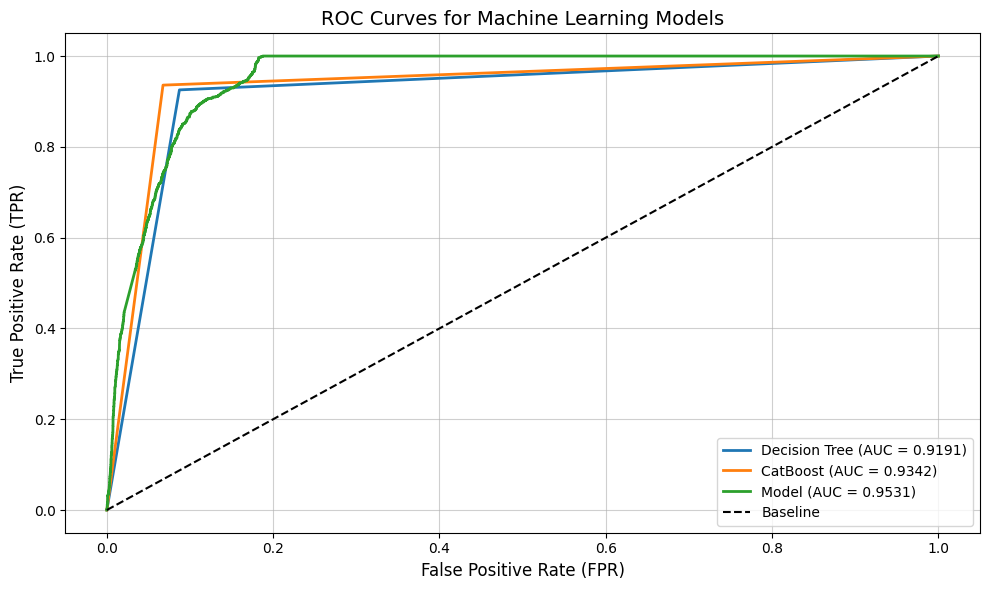

In [57]:
#get FPR, TPR, and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(ytest, yhat_dt)
auc_dt = roc_auc_score(ytest, yhat_dt)

#get FPR, TPR, and AUC for CatBoost
fpr_cb, tpr_cb, _ = roc_curve(ytest, yhat_cb)
auc_cb = roc_auc_score(ytest, yhat_cb)

#get FPR, TPR, and AUC for MLP
fpr_model, tpr_model, _ = roc_curve(ytest, y_pred)
auc_model = roc_auc_score(ytest, y_pred)

#plot the ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', linewidth=2)
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.4f})', linewidth=2)
plt.plot(fpr_model, tpr_model, label=f'Model (AUC = {auc_model:.4f})', linewidth=2)

#add the baseline plot
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Baseline')

#add titles, labels, and legend
plt.title('ROC Curves for Machine Learning Models', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.6)
plt.tight_layout()

# 4. Deep Learning Models:

In [19]:
Xtrain_dl = pd.read_csv("Xtrain_original.csv")
Xtest_dl = pd.read_csv("Xtest_original.csv")

ytrain_dl = pd.read_csv("ytrain_original.csv").squeeze()
ytest_dl = pd.read_csv("ytest_original.csv").squeeze()

In [29]:
#import the necessary parts of TensorFlow and the data_adapter
from tensorflow.python.keras.engine import data_adapter

#define the new method for checking distributed datasets
def _is_distributed_dataset(ds):
    #use DistributedDatasetSpec instead of the missing DistributedDatasetInterface
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

#apply the monkey patch by replacing the original method
data_adapter._is_distributed_dataset = _is_distributed_dataset

np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## 4.1. Wide and Deep:

### 4.1.1. Hyperparameter tuning:

In [30]:
#create copies of Xtrain and Xtest for Wide & Deep preprocessing
Xtrain_wandeepfm = Xtrain_dl.copy()
Xtest_wandeepfm = Xtest_dl.copy()

#identify dense and sparse features
dense_features = ['price']  # Only 'price' is dense
sparse_features = [col for col in Xtrain_wandeepfm.columns if col != 'price']  # All other columns are sparse

#first step: label Encoding for sparse features and Min-Max Scaling for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    Xtrain_wandeepfm[feat] = lbe.fit_transform(Xtrain_wandeepfm[feat])
    Xtest_wandeepfm[feat] = lbe.transform(Xtest_wandeepfm[feat])

mms = MinMaxScaler(feature_range=(0, 1))
Xtrain_wandeepfm[dense_features] = mms.fit_transform(Xtrain_wandeepfm[dense_features])
Xtest_wandeepfm[dense_features] = mms.transform(Xtest_wandeepfm[dense_features])

#second step: define feature columns for sparse and dense fields
fixlen_feature_columns_wandeepfm = [SparseFeat(feat, vocabulary_size=Xtrain_wandeepfm[feat].max() + 1, embedding_dim=4)
                                   for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]

dnn_feature_columns_wandeepfm = fixlen_feature_columns_wandeepfm
linear_feature_columns_wandeepfm = fixlen_feature_columns_wandeepfm

feature_names_wandeepfm = get_feature_names(linear_feature_columns_wandeepfm + dnn_feature_columns_wandeepfm)

#gnerate input data for the model
train_model_input_wandeepfm = {name: Xtrain_wandeepfm[name] for name in feature_names_wandeepfm}
test_model_input_wandeepfm = {name: Xtest_wandeepfm[name] for name in feature_names_wandeepfm}

#third step: hyperparameter optimisation
def objective(trial):
    #define hyperparameters to optimise
    dnn_hidden_units = trial.suggest_categorical("dnn_hidden_units", [(128, 128), (256, 256)])
    dnn_dropout = trial.suggest_float("dnn_dropout", 0, 0.5, step=0.1)

    #define the Wide & Deep model
    model = WDL(linear_feature_columns_wandeepfm, dnn_feature_columns_wandeepfm, task='binary',
                dnn_hidden_units=dnn_hidden_units, dnn_dropout=dnn_dropout)
    model.compile("adam", "binary_crossentropy", metrics=['AUC'])

    #train the model and report validation AUC
    for epoch in range(10):  # 10 epochs
        history = model.fit(
            train_model_input_wandeepfm, ytrain_dl.values,
            batch_size=256, epochs=1, verbose=0, validation_split=0.2,
        )
        #get the validation AUC
        val_auc = history.history['val_auc'][-1]

        #report intermediate value for pruning
        trial.report(val_auc, step=epoch)

        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_auc  #directly return AUC since we're maximising it

#create and run the Optuna study
study = optuna.create_study(direction="maximize")  #change direction to maximise AUC
study.optimize(objective, n_trials=20)

#print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-01-24 12:54:25,842] A new study created in memory with name: no-name-b49ffb9b-eb6a-4b19-89bb-09cd1ee56701
[I 2025-01-24 12:55:09,231] Trial 0 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.1}. Best is trial 0 with value: 0.5.
[I 2025-01-24 12:55:59,552] Trial 1 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.1}. Best is trial 0 with value: 0.5.
[I 2025-01-24 12:56:53,499] Trial 2 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.30000000000000004}. Best is trial 0 with value: 0.5.
[I 2025-01-24 12:57:40,181] Trial 3 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.5}. Best is trial 0 with value: 0.5.
[I 2025-01-24 12:58:26,263] Trial 4 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.4}. Best is trial 0 with value: 0.5.
[I 2025-01-24 12:59:18,839] Trial 5 finished with 

Best hyperparameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.1}


### 4.1.2. Testing set predictions:

In [31]:
#use the best hyperparameters to train the final model
best_dnn_hidden_units = study.best_params['dnn_hidden_units']
best_dnn_dropout = study.best_params['dnn_dropout']

final_model_wandeepfm = WDL(linear_feature_columns_wandeepfm, dnn_feature_columns_wandeepfm, task='binary',
                            dnn_hidden_units=best_dnn_hidden_units, dnn_dropout=best_dnn_dropout)
final_model_wandeepfm.compile("adam", "binary_crossentropy", metrics=['AUC'])

final_model_wandeepfm.fit(train_model_input_wandeepfm, ytrain_dl.values,
                          batch_size=256, epochs=10, verbose=2, validation_split=0.2)

#predict and evaluate the final model
pred_ans_wandeepfm = final_model_wandeepfm.predict(test_model_input_wandeepfm, batch_size=256)
print("Test AUC:", round(roc_auc_score(ytest_dl.values, pred_ans_wandeepfm), 4))

Epoch 1/10
312/312 - 11s - loss: 0.0579 - auc: 0.0000e+00 - val_loss: 3.9728 - val_auc: 0.5000
Epoch 2/10
312/312 - 4s - loss: 5.7923e-05 - auc: 0.0000e+00 - val_loss: 4.5021 - val_auc: 0.5000
Epoch 3/10
312/312 - 4s - loss: 5.5958e-05 - auc: 0.0000e+00 - val_loss: 4.7538 - val_auc: 0.5000
Epoch 4/10
312/312 - 4s - loss: 5.5060e-05 - auc: 0.0000e+00 - val_loss: 4.8617 - val_auc: 0.5000
Epoch 5/10
312/312 - 4s - loss: 5.4222e-05 - auc: 0.0000e+00 - val_loss: 4.8824 - val_auc: 0.5000
Epoch 6/10
312/312 - 4s - loss: 5.3420e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 7/10
312/312 - 4s - loss: 5.2724e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 8/10
312/312 - 4s - loss: 5.1870e-05 - auc: 0.0000e+00 - val_loss: 4.8838 - val_auc: 0.5000
Epoch 9/10
312/312 - 4s - loss: 5.0374e-05 - auc: 0.0000e+00 - val_loss: 4.8838 - val_auc: 0.5000
Epoch 10/10
312/312 - 4s - loss: 4.9433e-05 - auc: 0.0000e+00 - val_loss: 4.8838 - val_auc: 0.5000
Test AUC: 0.8057


The deep learning model Wide & Deep achieved an AUC score of 0.8057, significantly lower than the other machine learning models, suggesting that in this case, the deep learning model was not as effective in capturing the complexities of the data.

## 4.2. DeepFM:

### 4.2.1. Hyperparameter tuning:

In [32]:
#create copies of Xtrain and Xtest for DeepFM preprocessing
Xtrain_deepfm = Xtrain_dl.copy()
Xtest_deepfm = Xtest_dl.copy()

#identify dense and sparse features
dense_features = ['price']  # Only 'price' is dense
sparse_features = [col for col in Xtrain_deepfm.columns if col != 'price']  # All other columns are sparse

#first step: label Encoding for sparse features and Min-Max Scaling for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    Xtrain_deepfm[feat] = lbe.fit_transform(Xtrain_deepfm[feat])
    Xtest_deepfm[feat] = lbe.transform(Xtest_deepfm[feat])
mms = MinMaxScaler(feature_range=(0, 1))
Xtrain_deepfm[dense_features] = mms.fit_transform(Xtrain_deepfm[dense_features])
Xtest_deepfm[dense_features] = mms.transform(Xtest_deepfm[dense_features])

#second step: define feature columns for sparse and dense fields
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=Xtrain_deepfm[feat].max() + 1, embedding_dim=4)
                          for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

#generate input data for the model
train_model_input = {name: Xtrain_deepfm[name] for name in feature_names}
test_model_input = {name: Xtest_deepfm[name] for name in feature_names}

#third step: hyperparameter optimisation
def objective(trial):
    # Define hyperparameters to optimize
    dnn_hidden_units = trial.suggest_categorical("dnn_hidden_units", [(128, 128), (256, 256)])
    dnn_dropout = trial.suggest_float("dnn_dropout", 0, 0.5, step=0.1)

    # Define the model
    model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary',
                   dnn_hidden_units=dnn_hidden_units, dnn_dropout=dnn_dropout)
    model.compile("adam", "binary_crossentropy", metrics=['AUC'])

    # Train the model and report validation AUC
    for epoch in range(10):  # 10 epochs
        history = model.fit(
            train_model_input, ytrain_dl.values,
            batch_size=256, epochs=1, verbose=0, validation_split=0.2,
        )
        # Get the validation AUC
        val_auc = history.history['val_auc'][-1]

        # Report intermediate value for pruning
        trial.report(val_auc, step=epoch)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_auc  # Directly return AUC since we're maximizing it

#create and run the Optuna study
study = optuna.create_study(direction="maximize")  # Change direction to maximize
study.optimize(objective, n_trials=20)

#print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-01-24 13:12:04,084] A new study created in memory with name: no-name-b1059578-2cad-4fe0-998a-4b8e42ee225f
[I 2025-01-24 13:13:00,064] Trial 0 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.5}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:14:10,161] Trial 1 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.30000000000000004}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:15:11,438] Trial 2 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.2}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:15:58,394] Trial 3 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.30000000000000004}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:16:47,381] Trial 4 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.4}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:17:55,371] Trial 

Best hyperparameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.5}


### 4.2.2. Testing set predictions:

In [33]:
#use the best hyperparameters to train the final model
best_dnn_hidden_units = study.best_params['dnn_hidden_units']
best_dnn_dropout = study.best_params['dnn_dropout']

final_model_deepfm = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary',
                     dnn_hidden_units=best_dnn_hidden_units, dnn_dropout=best_dnn_dropout)
final_model_deepfm.compile("adam", "binary_crossentropy", metrics=['AUC'])

final_model_deepfm.fit(train_model_input, ytrain_dl.values,
                batch_size=256, epochs=10, verbose=2, validation_split=0.2)

# Predict and evaluate the final model
pred_ans_deepfm = final_model_deepfm.predict(test_model_input, batch_size=256)
print("Test AUC:", round(roc_auc_score(ytest_dl.values, pred_ans_deepfm), 4))

Epoch 1/10
312/312 - 12s - loss: 0.0259 - auc: 0.0000e+00 - val_loss: 4.1299 - val_auc: 0.5000
Epoch 2/10
312/312 - 3s - loss: 2.2048e-05 - auc: 0.0000e+00 - val_loss: 4.8835 - val_auc: 0.5000
Epoch 3/10
312/312 - 4s - loss: 1.8268e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 4/10
312/312 - 3s - loss: 1.6820e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 5/10
312/312 - 3s - loss: 1.5337e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 6/10
312/312 - 3s - loss: 1.4516e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 7/10
312/312 - 3s - loss: 1.3733e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 8/10
312/312 - 3s - loss: 1.2898e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 9/10
312/312 - 3s - loss: 1.2171e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 10/10
312/312 - 3s - loss: 1.1435e-05 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Test AUC: 0.7682


Despite its more complex architecture, the DeepFM model achieved a Test AUC of 0.7682, which is even lower than the Wide & Deep model's AUC of 0.8057. This underperformance suggests that, for this particular dataset, the more intricate structure of DeepFM may not have been advantageous.

## 4.3. xDeepFM:

### 4.3.1. Hyperparameter tuning:

In [34]:
#create copies of Xtrain and Xtest for xDeepFM preprocessing
Xtrain_xdeepfm = Xtrain_dl.copy()
Xtest_xdeepfm = Xtest_dl.copy()

#identify dense and sparse features
dense_features = ['price']  # Only 'price' is dense
sparse_features = [col for col in Xtrain_xdeepfm.columns if col != 'price']  # All other columns are sparse

#first step: label Encoding for sparse features and Min-Max Scaling for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    Xtrain_xdeepfm[feat] = lbe.fit_transform(Xtrain_xdeepfm[feat])
    Xtest_xdeepfm[feat] = lbe.transform(Xtest_xdeepfm[feat])
mms = MinMaxScaler(feature_range=(0, 1))
Xtrain_xdeepfm[dense_features] = mms.fit_transform(Xtrain_xdeepfm[dense_features])
Xtest_xdeepfm[dense_features] = mms.transform(Xtest_xdeepfm[dense_features])

#second step: define feature columns for sparse and dense fields
fixlen_feature_columns_xdeepfm = [SparseFeat(feat, vocabulary_size=Xtrain_xdeepfm[feat].max() + 1, embedding_dim=4)
                                   for feat in sparse_features] + [DenseFeat(feat, 1) for feat in dense_features]

dnn_feature_columns_xdeepfm = fixlen_feature_columns_xdeepfm
linear_feature_columns_xdeepfm = fixlen_feature_columns_xdeepfm

feature_names_xdeepfm = get_feature_names(linear_feature_columns_xdeepfm + dnn_feature_columns_xdeepfm)

#gnerate input data for the model
train_model_input_xdeepfm = {name: Xtrain_xdeepfm[name] for name in feature_names_xdeepfm}
test_model_input_xdeepfm = {name: Xtest_xdeepfm[name] for name in feature_names_xdeepfm}

#third step: hyperparameter optimisation
def objective(trial):
    #define hyperparameters to optimise
    dnn_hidden_units = trial.suggest_categorical("dnn_hidden_units", [(128, 128), (256, 256)])
    dnn_dropout = trial.suggest_float("dnn_dropout", 0, 0.5, step=0.1)

    #define the model
    model = xDeepFM(linear_feature_columns_xdeepfm, dnn_feature_columns_xdeepfm, task='binary',
                   dnn_hidden_units=dnn_hidden_units, dnn_dropout=dnn_dropout)
    model.compile("adam", "binary_crossentropy", metrics=['AUC'])

    #train the model and report validation AUC
    for epoch in range(10):  #10 epochs
        history = model.fit(
            train_model_input_xdeepfm, ytrain_dl.values,
            batch_size=256, epochs=1, verbose=0, validation_split=0.2,
        )
        #get the validation AUC
        val_auc = history.history['val_auc'][-1]

        #report intermediate value for pruning
        trial.report(val_auc, step=epoch)

        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_auc  #directly return AUC since we're maximizing it

#create and run the Optuna study
study = optuna.create_study(direction="maximize")  # Change direction to maximize
study.optimize(objective, n_trials=20)

#print the best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-01-24 13:30:50,698] A new study created in memory with name: no-name-a71b0941-a014-48f3-ae8c-c1b3f30545f9
[I 2025-01-24 13:35:09,940] Trial 0 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.2}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:39:37,569] Trial 1 finished with value: 0.5 and parameters: {'dnn_hidden_units': (128, 128), 'dnn_dropout': 0.0}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:44:25,425] Trial 2 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.0}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:48:45,151] Trial 3 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.4}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:53:10,584] Trial 4 finished with value: 0.5 and parameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.0}. Best is trial 0 with value: 0.5.
[I 2025-01-24 13:57:39,401] Trial 5 finished with value: 0.5 and p

Best hyperparameters: {'dnn_hidden_units': (256, 256), 'dnn_dropout': 0.2}


### 4.3.2. Testing set prediction:

In [35]:
#use the best hyperparameters to train the final model
best_dnn_hidden_units = study.best_params['dnn_hidden_units']
best_dnn_dropout = study.best_params['dnn_dropout']

final_model_xdeepfm = xDeepFM(linear_feature_columns_xdeepfm, dnn_feature_columns_xdeepfm, task='binary',
                             dnn_hidden_units=best_dnn_hidden_units, dnn_dropout=best_dnn_dropout)
final_model_xdeepfm.compile("adam", "binary_crossentropy", metrics=['AUC'])

final_model_xdeepfm.fit(train_model_input_xdeepfm, ytrain_dl.values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2)

#predict and evaluate the final model
pred_ans_xdeepfm = final_model_xdeepfm.predict(test_model_input_xdeepfm, batch_size=256)
print("Test AUC:", round(roc_auc_score(ytest_dl.values, pred_ans_xdeepfm), 4))

Epoch 1/10
312/312 - 34s - loss: 0.0199 - auc: 0.0000e+00 - val_loss: 4.2164 - val_auc: 0.5000
Epoch 2/10
312/312 - 26s - loss: 8.6156e-06 - auc: 0.0000e+00 - val_loss: 4.6897 - val_auc: 0.5000
Epoch 3/10
312/312 - 26s - loss: 7.4754e-06 - auc: 0.0000e+00 - val_loss: 4.8375 - val_auc: 0.5000
Epoch 4/10
312/312 - 25s - loss: 6.7306e-06 - auc: 0.0000e+00 - val_loss: 4.8773 - val_auc: 0.5000
Epoch 5/10
312/312 - 26s - loss: 6.0430e-06 - auc: 0.0000e+00 - val_loss: 4.8826 - val_auc: 0.5000
Epoch 6/10
312/312 - 26s - loss: 5.4346e-06 - auc: 0.0000e+00 - val_loss: 4.8835 - val_auc: 0.5000
Epoch 7/10
312/312 - 26s - loss: 4.8883e-06 - auc: 0.0000e+00 - val_loss: 4.8836 - val_auc: 0.5000
Epoch 8/10
312/312 - 26s - loss: 4.4096e-06 - auc: 0.0000e+00 - val_loss: 4.8836 - val_auc: 0.5000
Epoch 9/10
312/312 - 25s - loss: 3.9903e-06 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Epoch 10/10
312/312 - 25s - loss: 3.6231e-06 - auc: 0.0000e+00 - val_loss: 4.8837 - val_auc: 0.5000
Test AUC: 0.7

Despite its more complex architecture, XDeepFM achieved a lower AUC (0.7609) than both DeepFM (0.7682) and Wide & Deep (0.8057). This suggests that the additional complexity did not improve performance, possibly due to the dataset not benefiting from such intricate feature interactions. the "simple" model like Wide & Deep outperformed the other models this case.

## 4.4. Machine Learning Models ROC Curve Visualisation

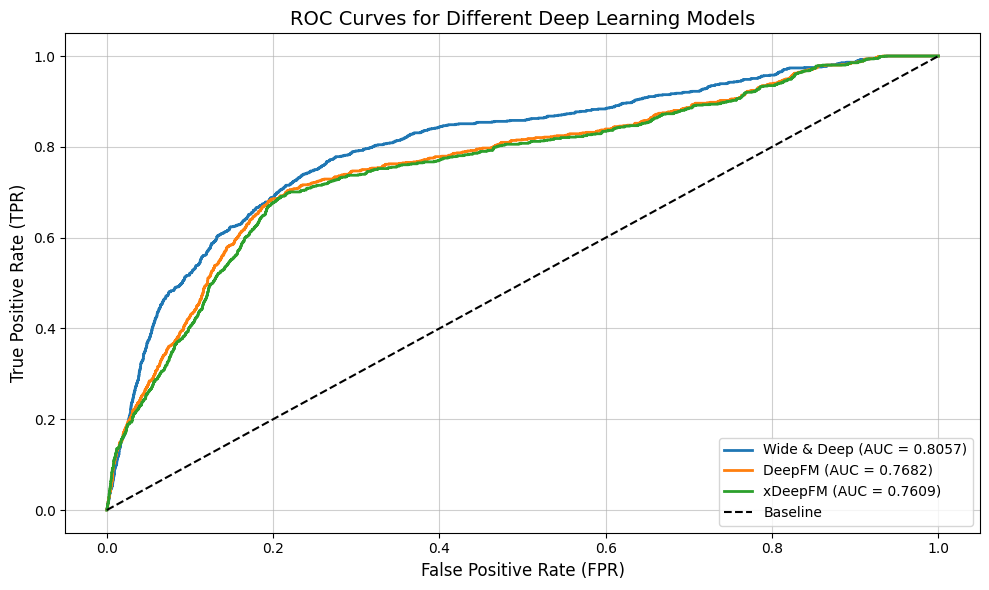

In [59]:
#calculate FPR, TPR, and AUC for Wide & Deep
fpr_wide_deep, tpr_wide_deep, _ = roc_curve(ytest_dl.values, pred_ans_wandeepfm)
auc_wide_deep = roc_auc_score(ytest_dl.values, pred_ans_wandeepfm)

#calculate FPR, TPR, and AUC for DeepFM
fpr_deepfm, tpr_deepfm, _ = roc_curve(ytest_dl.values, pred_ans_deepfm)
auc_deepfm = roc_auc_score(ytest_dl.values, pred_ans_deepfm)

#calculate FPR, TPR, and AUC for xDeepFM
fpr_xdeepfm, tpr_xdeepfm, _ = roc_curve(ytest_dl.values, pred_ans_xdeepfm)
auc_xdeepfm = roc_auc_score(ytest_dl.values, pred_ans_xdeepfm)

#plot ROC curves for Wide & Deep, DeepFM, and xDeepFM
plt.figure(figsize=(10, 6))
plt.plot(fpr_wide_deep, tpr_wide_deep, label=f'Wide & Deep (AUC = {auc_wide_deep:.4f})', linewidth=2)
plt.plot(fpr_deepfm, tpr_deepfm, label=f'DeepFM (AUC = {auc_deepfm:.4f})', linewidth=2)
plt.plot(fpr_xdeepfm, tpr_xdeepfm, label=f'xDeepFM (AUC = {auc_xdeepfm:.4f})', linewidth=2)

#plot the baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Baseline')

#add titles, labels, and legend
plt.title('ROC Curves for Different Deep Learning Models', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.6)
plt.tight_layout()

# 5. All Models ROC Curve Visualisation

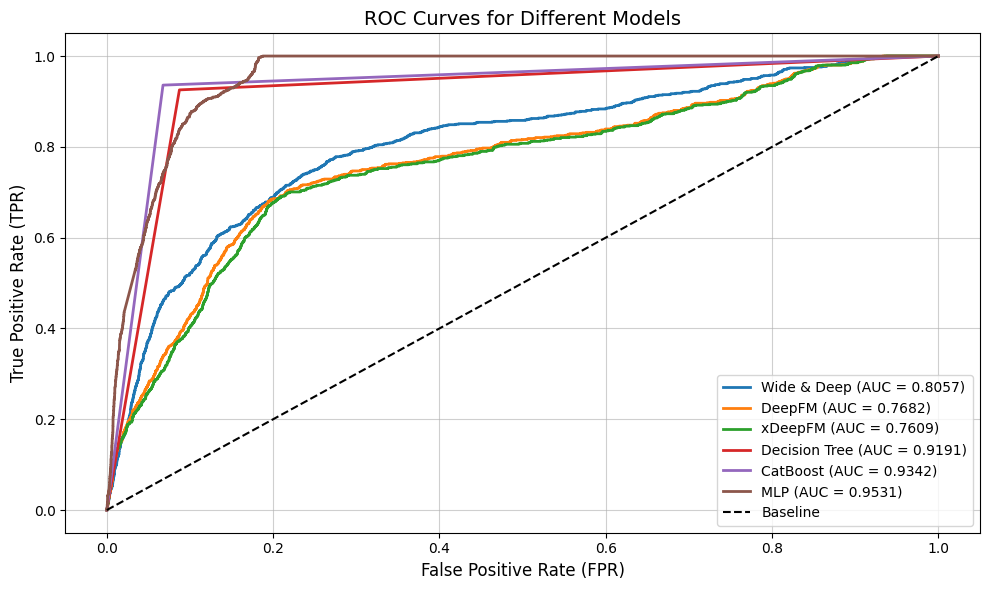

In [60]:
#plot ROC curves for Wide & Deep, DeepFM, and xDeepFM
plt.figure(figsize=(10, 6))
plt.plot(fpr_wide_deep, tpr_wide_deep, label=f'Wide & Deep (AUC = {auc_wide_deep:.4f})', linewidth=2)
plt.plot(fpr_deepfm, tpr_deepfm, label=f'DeepFM (AUC = {auc_deepfm:.4f})', linewidth=2)
plt.plot(fpr_xdeepfm, tpr_xdeepfm, label=f'xDeepFM (AUC = {auc_xdeepfm:.4f})', linewidth=2)

#plot ROC curves for Decision Tree, CatBoost, and  MLP
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', linewidth=2)
plt.plot(fpr_cb, tpr_cb, label=f'CatBoost (AUC = {auc_cb:.4f})', linewidth=2)
plt.plot(fpr_model, tpr_model, label=f'MLP (AUC = {auc_model:.4f})', linewidth=2)

#plot the baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Baseline')

#add titles, labels, and legend
plt.title('ROC Curves for Different Models', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.6)
plt.tight_layout()

# 6. SHAP values:

## 6.1. Top features for Keras MLP:

In [254]:
#load the best model and top features
best_model = load_model('best_model.h5')  #load the Keras model
best_top_features = joblib.load('best_top_features_keras_rfe.pkl')  #load the selected features

#preprocess Xtest to select the same features used for training
Xtest_selected = Xtest[best_top_features]  #ensure Xtest contains only the top features

#define silent_predict function
def silent_predict(model, X):
    """
    Predicts probabilities using the model without verbose output.
    """
    tf.get_logger().setLevel('ERROR')  #suppress TensorFlow logs
    return model.predict(X, verbose=0).flatten()  #use verbose=0 in predict()

#define compute_permutation_importance function
def compute_permutation_importance(model, X, y, random_state=7):
    """
    Computes permutation importance for features in X.
    """
    np.random.seed(random_state)  #set random seed
    importances = []
    
    #get baseline predictions and AUC score
    baseline_preds = silent_predict(model, X)
    baseline_auc = roc_auc_score(y, baseline_preds)
    
    for col in X.columns:
        #create a copy of X and permute one column
        X_permuted = X.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])  #shuffle the column
        
        #predict on permuted data and compute AUC score
        permuted_preds = silent_predict(model, X_permuted)
        permuted_auc = roc_auc_score(y, permuted_preds)
        
        #importance is the drop in AUC from the baseline to the permuted version
        importance = baseline_auc - permuted_auc
        importances.append((col, importance))
    
    #sort features by importance (highest to lowest)
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances, baseline_auc

#compute permutation importance
importances, baseline_auc = compute_permutation_importance(best_model, Xtest_selected, ytest)

#display top features by importance
top_features_keras = pd.DataFrame(importances, columns=['Feature', 'Importance']).head(10)

print("Top 10 Features by Permutation Importance:")
print(top_features_keras)

Top 10 Features by Permutation Importance:
                            Feature  Importance
0              adgroup_Rare Adgroup    0.178864
1                             price    0.029051
2  advertiser_Occasional Advertiser    0.009070
3    advertiser_Moderate Advertiser    0.009016
4          adgroup_Moderate Adgroup    0.008282
5            campaign_Rare Campaign    0.007113
6        category_Frequent Category    0.006758
7                 brand_Heavy Brand    0.005968
8        category_Moderate Category    0.004990
9            brand_Occasional Brand    0.004457


## 6.2. SHAP values:

In [192]:
#preprocess Xtest to select the same features used for training
Xtest_selected = Xtest[best_top_features]  #ensure Xtest contains only the top features

#make predictions on Xtest
y_pred = best_model.predict(Xtest_selected)  #predict probabilities for the positive class

#calculate the AUC score
auc_score_test = roc_auc_score(ytest, y_pred)  #compare with true labels (ytest)
print(f"AUC Score on Xtest: {auc_score_test:.3f}")

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
AUC Score on Xtest: 0.967


In [193]:
#preprocess Xtrain to select the same features used for training
Xtrain_selected = Xtrain[best_top_features]  # Ensure Xtrain contains only the top features

#convert Xtrain_selected to a NumPy array for SHAP compatibility
Xtrain_np_nn = np.array(Xtrain_selected)

#initialise SHAP GradientExplainer
explainer_nn_shap = shap.GradientExplainer(best_model, Xtrain_np_nn) 

#compute SHAP values
start_time = time.time()
shap_values_nn = explainer_nn_shap.shap_values(Xtrain_np_nn)  
end_time = time.time()

#print the shape of SHAP values and computation time
elapsed_time = end_time - start_time
print(f"SHAP Values shape: {np.array(shap_values_nn).shape}")
print(f"Time taken to compute SHAP values: {elapsed_time:.2f} seconds")

SHAP Values shape: (99568, 20, 1)
Time taken to compute SHAP values: 1768.13 seconds


In [196]:
#get SHAP values 
shap_values_class_1_nn = shap_values_nn[:, :, 0]

#print the shape
print(f"Shape of SHAP values for class 1: {shap_values_class_1_nn.shape}")

Shape of SHAP values for class 1: (99568, 20)


In [197]:
#calculate the mean of absolute SHAP values for class 1
mean_shap_class_1_nn = np.abs(shap_values_class_1_nn).mean(axis=0)

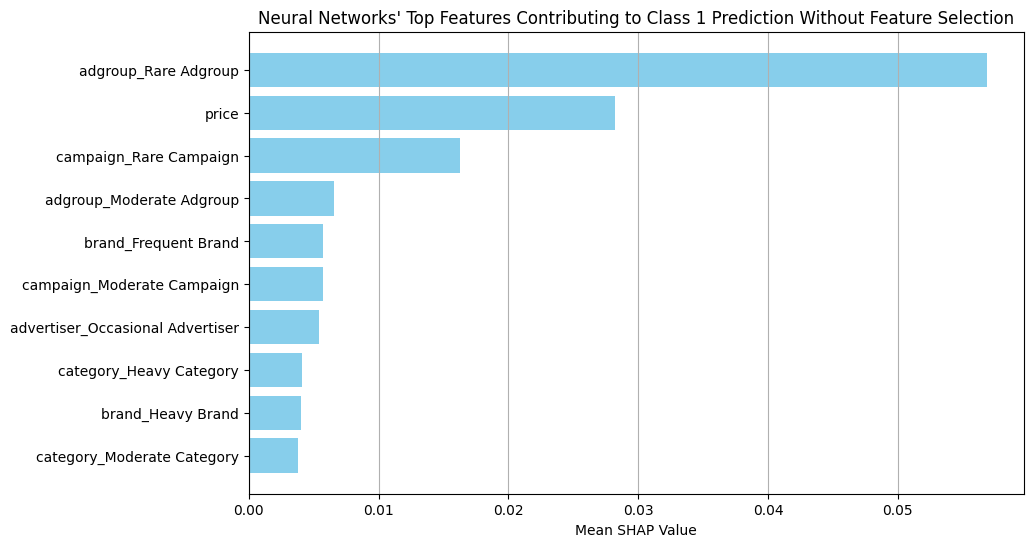

In [199]:
#create a df for better visualisation
feature_names_nn = Xtrain_selected.columns 
mean_shap_nn = pd.DataFrame({
    'Feature': feature_names_nn,
    'Mean SHAP Value': mean_shap_class_1_nn})

#sort df by 'Mean SHAP Value' in descending order
sorted_shap_nn = mean_shap_nn.sort_values(by='Mean SHAP Value', ascending=False)

#select top 10 features that contribute positively to class 1
top_10_features_nn = sorted_shap_nn.head(10)

#visualise the top 10 features' contribution
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_nn['Feature'], top_10_features_nn['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.title("Neural Networks' Top Features Contributing to Class 1 Prediction")
plt.grid(axis='x')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest mean SHAP value at the top
plt.show()